#  Setup

To begin, we will first import all of the necessary packages and our dataset, which will be a Statcast query returning all pitch data collected for the 2022 MLB regular season.

In [1]:
!pip install pybaseball
import pybaseball
from pybaseball import statcast, statcast_pitcher, playerid_lookup

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, plot_roc_curve, roc_curve, auc, RocCurveDisplay, f1_score, recall_score, precision_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from operator import itemgetter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 4.0 MB/s 
     |████████████████████████████████| 297 kB 53.6 MB/s 
     |████████████████████████████████| 856 kB 51.7 MB/s 


In [2]:
pybaseball.cache.enable()
statcast = statcast('2022-04-07', '2022-10-05')
statcast.head(10)

This is a large query, it may take a moment to complete


100%|██████████| 182/182 [06:12<00:00,  2.05s/it]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3261,CH,2022-10-05,80.8,-0.76,6.61,"Baker, Bryan",624415,641329,field_out,hit_into_play,...,5,4,5,4,5,Infield shift,Standard,213,0.035,-0.099
3325,FF,2022-10-05,97.7,-0.58,6.6,"Baker, Bryan",643376,641329,strikeout,swinging_strike,...,5,4,5,4,5,Standard,Standard,189,0.052,-0.134
3466,CH,2022-10-05,84.9,-0.55,6.58,"Baker, Bryan",643376,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,212,0.0,0.023
3608,FF,2022-10-05,97.2,-0.42,6.6,"Baker, Bryan",643376,641329,NaN,swinging_strike,...,5,4,5,4,5,Standard,Standard,192,0.0,-0.036
3838,FC,2022-10-05,86.2,-0.55,6.64,"Baker, Bryan",643376,641329,NaN,called_strike,...,5,4,5,4,5,Standard,Standard,127,0.0,-0.031
3967,FF,2022-10-05,97.5,-0.56,6.68,"Baker, Bryan",643376,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,194,0.0,0.023
4122,CH,2022-10-05,84.9,-0.58,6.65,"Baker, Bryan",665489,641329,strikeout,called_strike,...,5,4,5,4,5,Standard,Standard,207,0.071,-0.158
4190,FF,2022-10-05,98.2,-0.59,6.72,"Baker, Bryan",665489,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,190,0.0,0.017
4361,CH,2022-10-05,83.8,-0.41,6.57,"Baker, Bryan",665489,641329,NaN,called_strike,...,5,4,5,4,5,Standard,Standard,211,0.0,-0.046
4582,FF,2022-10-05,96.7,-0.41,6.75,"Baker, Bryan",665489,641329,NaN,swinging_strike,...,5,4,5,4,5,Standard,Standard,192,0.0,-0.034


In [3]:
data = statcast
print(data.shape)

(708540, 92)


In [4]:
for i in zip(data.columns, data.dtypes):
  print(i)

('pitch_type', dtype('O'))
('game_date', dtype('<M8[ns]'))
('release_speed', Float64Dtype())
('release_pos_x', Float64Dtype())
('release_pos_z', Float64Dtype())
('player_name', dtype('O'))
('batter', Int64Dtype())
('pitcher', Int64Dtype())
('events', dtype('O'))
('description', dtype('O'))
('spin_dir', Int64Dtype())
('spin_rate_deprecated', Int64Dtype())
('break_angle_deprecated', Int64Dtype())
('break_length_deprecated', Int64Dtype())
('zone', Int64Dtype())
('des', dtype('O'))
('game_type', dtype('O'))
('stand', dtype('O'))
('p_throws', dtype('O'))
('home_team', dtype('O'))
('away_team', dtype('O'))
('type', dtype('O'))
('hit_location', Int64Dtype())
('bb_type', dtype('O'))
('balls', Int64Dtype())
('strikes', Int64Dtype())
('game_year', Int64Dtype())
('pfx_x', Float64Dtype())
('pfx_z', Float64Dtype())
('plate_x', Float64Dtype())
('plate_z', Float64Dtype())
('on_3b', Int64Dtype())
('on_2b', Int64Dtype())
('on_1b', Int64Dtype())
('outs_when_up', Int64Dtype())
('inning', Int64Dtype())
('

# Data Cleaning

## Feature Selection (First Pass)

Feature selection will be done based on the Statcast descriptions for every metric Hawkeye is able to collect and calculate [1]. Because these metrics will be used to build a pitch classifier, we can first narrow down our features to those that are derived from the pitch itself, including the release spin rate, velocity, pitch type, etc. 

We want to assume as little about the pitcher as possible, so we will exlcude any information about pitchers that will not be important to any model. Therefore, we include only the pitcher's handedness (R or L) as a first pass feature because of the different pitch mixes and pitch frequencies that differ between left and right-handed pitchers. Some examples include RHP having a higher use of splitters than LHP, or that RHP may throw a higher percetange of sliders than LHP. The code below confirms these observations based on all 2022 pitch data.

[1]: BaseballSavant. “Statcast Documentation.” Dec 2022, https://baseballsavant.mlb.com/csv-docs.

In [5]:
# First pass pitch metrics used as features in model
pitch_chars = ["player_name","p_throws",'pitch_type','pitch_name', 'effective_speed', 'release_spin_rate', 'spin_axis', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z']
data = data[pitch_chars]
data.head(10)

,player_name,p_throws,pitch_type,pitch_name,effective_speed,release_spin_rate,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
3261,"Baker, Bryan",R,CH,Changeup,81.5,1771,213,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.8,-0.32,2.24
3325,"Baker, Bryan",R,FF,4-Seam Fastball,98.1,2434,189,2.238826,-142.091777,-8.96856,-2.851911,33.061824,-8.887788,-0.17,1.58,0.1,2.59
3466,"Baker, Bryan",R,CH,Changeup,85.2,1856,212,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3608,"Baker, Bryan",R,FF,4-Seam Fastball,97.5,2258,192,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.3
3838,"Baker, Bryan",R,FC,Cutter,86.7,2348,127,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.0,0.36,3.0
3967,"Baker, Bryan",R,FF,4-Seam Fastball,98.1,2341,194,3.602388,-141.992356,-5.678525,-2.810909,32.024156,-10.386902,-0.15,1.53,0.65,3.84
4122,"Baker, Bryan",R,CH,Changeup,85.0,1814,207,6.058436,-123.509978,-4.531087,-13.199871,24.457769,-22.525505,-1.17,0.87,1.0,2.76
4190,"Baker, Bryan",R,FF,4-Seam Fastball,98.4,2416,190,3.420756,-142.928844,-4.118459,-2.786269,34.797504,-8.64687,-0.14,1.67,0.54,4.6
4361,"Baker, Bryan",R,CH,Changeup,84.8,1750,211,4.366144,-121.971583,-5.73606,-12.805675,21.782046,-25.333601,-1.2,0.6,0.44,1.87
4582,"Baker, Bryan",R,FF,4-Seam Fastball,97.1,2328,192,0.92005,-140.825612,-5.009756,-2.690527,30.878154,-11.178099,-0.19,1.51,-0.22,4.09


In [6]:
# Print features and their datatypes for first pass selected features
for i in zip(data.columns, data.dtypes):
  print(i)

('player_name', dtype('O'))
('p_throws', dtype('O'))
('pitch_type', dtype('O'))
('pitch_name', dtype('O'))
('effective_speed', Float64Dtype())
('release_spin_rate', Int64Dtype())
('spin_axis', Int64Dtype())
('vx0', Float64Dtype())
('vy0', Float64Dtype())
('vz0', Float64Dtype())
('ax', Float64Dtype())
('ay', Float64Dtype())
('az', Float64Dtype())
('pfx_x', Float64Dtype())
('pfx_z', Float64Dtype())
('plate_x', Float64Dtype())
('plate_z', Float64Dtype())


In [7]:
# Returns absolute pitch frequency for pitches thrown by LHP and RHP respectively
data.groupby(['p_throws']).pitch_name.value_counts()

p_throws  pitch_name     
L         4-Seam Fastball     65021
          Slider              36056
          Sinker              31643
          Changeup            27861
          Curveball           18476
          Cutter              12089
          Knuckle Curve        2145
          Split-Finger          361
          Eephus                 68
          Fastball               18
R         4-Seam Fastball    167929
          Slider             111460
          Sinker              79760
          Changeup            52414
          Curveball           41094
          Cutter              38673
          Knuckle Curve       11396
          Split-Finger         9997
          Fastball             1261
          Eephus                426
          Knuckleball            19
Name: pitch_name, dtype: int64

In [8]:
# Returns absolute frequency of total pitches thrown by LHP and RHP
data.p_throws.value_counts()

R    514588
L    193952
Name: p_throws, dtype: int64

As shown by the absolute pitch frequencies of LHP and RHP, one could confirm the examples cited above. However, the frequencies of pitcher-handedness shows that there are much more RHP than LHP, meaning that more pitches will be thrown by RHP than LHP in absolute terms (obviously). To solve for this, we simply make the frequency of pitches thrown by LHP and RHP relative to the number of pitches thrown by each class of pitchers respectively. Our result will be  percentages designating the frequency of each pitch relative to RHP and LHP.

In [9]:
# Stores total amount of pitches thrown by LHP and RHP respectively
LH_pitches = data.p_throws.value_counts()['L']
RH_pitches = data.p_throws.value_counts()['R']

In [10]:
# Returns first frequency table now normalized to total frequency of pitches thrown by LHP and RHP over the whole dataset

print("Relative Pitch Frequency LHP: \n", round((data.groupby(['p_throws']).pitch_name.value_counts()['L'] / LH_pitches) * 100, 2))
print(" ")
print("Relative Pitch Frequency RHP: \n", round((data.groupby(['p_throws']).pitch_name.value_counts()['R'] / RH_pitches) * 100, 2))

Relative Pitch Frequency LHP: 
 pitch_name
4-Seam Fastball    33.52
Slider             18.59
Sinker             16.31
Changeup           14.36
Curveball           9.53
Cutter              6.23
Knuckle Curve       1.11
Split-Finger        0.19
Eephus              0.04
Fastball            0.01
Name: pitch_name, dtype: float64
 
Relative Pitch Frequency RHP: 
 pitch_name
4-Seam Fastball    32.63
Slider             21.66
Sinker             15.50
Changeup           10.19
Curveball           7.99
Cutter              7.52
Knuckle Curve       2.21
Split-Finger        1.94
Fastball            0.25
Eephus              0.08
Knuckleball         0.00
Name: pitch_name, dtype: float64


After normalizing for pitcher handedness, we can see that there are some differences in pitch frequency worth noting. For one, RHP do throw a much larger percentage of splitters in comparison to LHP, as well as knuckle-curves and sliders. On the other hand, LHP actually throw a higher percentage of changeups than do RHP. These differences lend some credence to the notion of keeping pitcher handedness as a feature to include in a classifier model.

## Cleaning

### Removing "Outliers"

While we initially selected some features to include in a model, we still have not cleaned our data according to those features. This typically includes some handling of "outliers," which would apply to a pitch classifier as pitches that are either difficult to classify or pitches with frequencies low enough to warrant exclusion of. Luckily, if we look at the absolute frequencies of all uniquely classified pitches, Statcast has done some classification to purposely include some pitches in exclusionary categories. For our purposes, our outliers of the dataset are pitches thrown by position players finshing the last innings of a rout. Their specific pitches are where we turn our focus to: Fastballs, Eephus', and Kunckleballs.

In [11]:
# Absolute frequency table for pitch names
pitch_names = data.pitch_name.value_counts()
pitch_names

4-Seam Fastball    232950
Slider             147516
Sinker             111403
Changeup            80275
Curveball           59570
Cutter              50762
Knuckle Curve       13541
Split-Finger        10358
Fastball             1279
Eephus                494
Knuckleball            19
Name: pitch_name, dtype: int64

In [12]:
# Absolute frequency table for pitch types
pitch_types = data.pitch_type.value_counts()
pitch_types

FF    232950
SL    147516
SI    111403
CH     80275
CU     59473
FC     50762
KC     13541
FS     10358
FA      1279
EP       494
CS        97
KN        19
Name: pitch_type, dtype: int64

From examining frequencies of pitch name and pitch type, we spot a little variation. Specifically, there are 12 unique pitch types, but only 11 unique pitch names. There are 97 instances of a pitch type "CS," which warrant further exploration.

In [13]:
# Return the dataset to include only 'CS' designated instances
data[data['pitch_type'] == 'CS']

,player_name,p_throws,pitch_type,pitch_name,effective_speed,release_spin_rate,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
345,"Mikolas, Miles",R,CS,Curveball,59.6,1895,26,-0.860537,-87.393557,4.107304,2.259695,15.094675,-39.757998,0.42,-1.31,-2.25,2.42
1197,"Wainwright, Adam",R,CS,Curveball,66.8,2590,31,-2.584818,-98.309038,1.489356,7.626269,15.874985,-40.85004,1.11,-1.27,-1.68,1.94
1611,"Hill, Rich",L,CS,Curveball,65.8,2364,314,-0.669038,-96.986903,5.331442,-8.729238,18.916258,-39.378614,-1.43,-0.95,0.11,3.37
3585,"Hill, Rich",L,CS,Curveball,67.3,2553,310,-2.483632,-99.534736,2.155108,-8.571723,18.635451,-39.815738,-1.38,-1.06,-0.83,2.12
43,"Mikolas, Miles",R,CS,Curveball,65.8,2031,34,3.285629,-95.347678,1.577908,1.932784,15.665717,-39.923789,0.41,-1.2,-0.05,1.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081,"McHugh, Collin",R,CS,Curveball,68.2,2469,44,-0.29298,-99.491757,8.532536,8.412394,16.724007,-39.798935,1.26,-0.9,-0.98,5.42
3043,"McHugh, Collin",R,CS,Curveball,68.1,2637,34,2.338207,-98.864735,0.309101,6.353832,17.059953,-40.050809,1.04,-1.16,0.19,0.8
150,"Wainwright, Adam",R,CS,Curveball,68.0,2498,42,-0.290942,-100.641489,3.063782,11.071765,21.602237,-42.408961,1.66,-1.4,0.01,2.72
1174,"Wainwright, Adam",R,CS,Curveball,68.1,2332,41,0.009093,-100.291318,1.588061,8.206547,20.323303,-40.96119,1.24,-1.24,-0.13,2.09


In [14]:
# Find pitchers who throw 'CS'
data[data['pitch_type'] == 'CS'].player_name.value_counts()

Wainwright, Adam    36
Hill, Rich          20
Duffey, Tyler       18
Mikolas, Miles      12
McHugh, Collin      11
Name: player_name, dtype: int64

On first pass, the name column shows that it is exclusively five pitchers that throw these specific curveballs. The question of why these are specifically designated pitch types are not in this project's scope, so for our purposes we will choose to leave these speific instances alone.

In [15]:
# Return the dataset to include only 'Fastball' designated instances
data[data['pitch_name'] == 'Fastball']

,player_name,p_throws,pitch_type,pitch_name,effective_speed,release_spin_rate,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
2770,"Torrens, Luis",R,FA,Fastball,87.4,2028,198,5.908894,-129.211593,-6.160026,-9.017058,23.988244,-16.007847,-0.7,1.34,0.83,2.94
2902,"Torrens, Luis",R,FA,Fastball,86.0,2013,210,7.76704,-126.695007,-5.562338,-13.780615,23.24916,-19.449337,-1.14,1.09,0.36,2.11
2963,"Torrens, Luis",R,FA,Fastball,83.5,2006,215,5.576926,-123.404175,-4.159193,-5.468194,23.603541,-16.933643,-0.43,1.43,0.36,2.97
3135,"Torrens, Luis",R,FA,Fastball,84.2,1920,205,8.035447,-123.70906,-4.118744,-8.74414,22.83086,-21.535999,-0.7,0.97,1.11,2.37
3213,"Torrens, Luis",R,FA,Fastball,85.1,1929,197,10.013253,-125.686932,-5.303777,-13.215244,24.124622,-19.228439,-1.06,1.13,1.72,2.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651,"Kelly, Carson",R,FA,Fastball,76.1,1857,205,5.157492,-114.128093,-3.105126,-2.84336,26.246587,-16.087129,-0.19,1.82,0.61,3.86
3895,"Kelly, Carson",R,FA,Fastball,63.3,1592,206,4.6374,-95.083521,-3.870533,-5.016676,17.420544,-21.174033,-0.7,1.76,0.39,1.62
4176,"Kelly, Carson",R,FA,Fastball,76.6,1949,211,6.208427,-114.661908,-5.294731,-6.994042,25.365648,-17.54007,-0.65,1.58,0.79,2.66
4240,"Kelly, Carson",R,FA,Fastball,63.4,1509,210,2.917025,-94.862012,-4.324639,-3.695498,16.350107,-21.96135,-0.53,1.62,-0.38,1.32


In [16]:
# Return the dataset to include pitchers who threw a desingated 'Fastball'
data[data['pitch_name'] == 'Fastball'].player_name.value_counts()

Alberto, Hanser           151
Gordon, Nick               85
Kelly, Carson              67
VanMeter, Josh             62
Phillips, Brett            59
Harrison, Josh             51
Stubbs, Garrett            45
Brosseau, Mike             44
Myers, Wil                 38
Torrens, Luis              33
Clement, Ernie             32
McKenna, Ryan              31
Hager, Jake                28
Strange-Gordon, Dee        28
Bethancourt, Christian     27
Bradley Jr., Jackie        27
Pinder, Chad               26
Castillo, Diego            26
Schrock, Max               26
Culberson, Charlie         26
Maton, Nick                25
Schwindel, Frank           24
Simmons, Andrelton         21
Reynolds, Matt             20
Pujols, Albert             19
González, Luis             18
Leon, Sandy                17
Castro, Harold             16
Ford, Mike                 15
Plawecki, Kevin            14
Caratini, Victor           14
Dickerson, Corey           12
Merrifield, Whit           12
Molina, Ya

In [17]:
# Repeat above for Eephus
data[data['pitch_name'] == 'Eephus']

,player_name,p_throws,pitch_type,pitch_name,effective_speed,release_spin_rate,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
3739,"Vargas, Ildemaro",R,EP,Eephus,37.1,841,204,0.657855,-54.45668,11.293683,0.051253,5.996353,-30.418288,0.06,1.67,-0.16,4.32
4010,"Vargas, Ildemaro",R,EP,Eephus,37.2,812,216,-0.237409,-54.731675,12.31373,-0.238409,5.931549,-30.79085,-0.13,1.51,-0.99,5.2
4332,"Vargas, Ildemaro",R,EP,Eephus,37.6,898,214,1.599343,-55.654232,9.203681,-0.112455,6.065402,-29.648962,0.03,1.86,0.5,2.68
4437,"Vargas, Ildemaro",R,EP,Eephus,37.7,786,200,-0.054562,-55.025723,10.620663,0.609237,4.665442,-30.573263,0.3,1.33,-0.71,3.81
2850,"Clemens, Kody",R,EP,Eephus,44.3,1042,201,0.513493,-66.848762,5.700501,-0.052311,5.908564,-28.959118,0.0,1.28,-0.85,3.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3712,"Castillo, Diego",R,EP,Eephus,66.6,1658,215,6.064892,-97.949027,0.604866,-1.991434,14.706473,-20.967695,-0.17,1.78,1.63,3.66
2004,"Myers, Wil",R,EP,Eephus,49.3,1881,29,0.924721,-74.678987,3.75027,3.443837,10.185812,-37.814632,0.96,-1.32,0.52,1.22
2411,"Myers, Wil",R,EP,Eephus,52.1,1982,41,2.643121,-79.223556,3.304773,2.718303,12.443245,-38.14039,0.76,-1.25,1.46,1.36
3034,"Myers, Wil",R,EP,Eephus,52.9,1991,35,1.963514,-80.321091,2.368406,3.810391,12.177114,-38.965036,0.96,-1.45,0.83,0.68


In [18]:
# Eephus throwers
data[data['pitch_name'] == 'Eephus'].player_name.value_counts()

Clemens, Kody             86
González, Luis            68
Castro, Harold            34
Castillo, Diego           34
Bethancourt, Christian    25
Neuse, Sheldon            24
Batten, Matthew           23
Chang, Yu                 22
Lopez, Alejo              19
Astudillo, Willians       17
Schwindel, Frank          16
Stubbs, Garrett           15
Ruf, Darin                14
Walton, Donovan           13
VanMeter, Josh            12
Escobar, Alcides           9
Wynns, Austin              9
Reyes, Pablo               8
Arcia, Orlando             8
Sanchez, Carlos            7
Knizner, Andrew            6
Dickerson, Corey           6
Myers, Wil                 5
Vargas, Ildemaro           4
Bradley Jr., Jackie        3
Palacios, Jermaine         3
Gonzalez, Marwin           2
Alberto, Hanser            1
Molina, Yadier             1
Name: player_name, dtype: int64

In [19]:
# Knuckeballs
data[data['pitch_name'] == 'Knuckleball']

,player_name,p_throws,pitch_type,pitch_name,effective_speed,release_spin_rate,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
2784,"Clement, Ernie",R,KN,Knuckleball,49.3,1065,216,-0.396687,-72.632626,2.717848,-1.610823,8.003952,-28.684959,-0.47,1.12,-2.39,1.3
3302,"Clement, Ernie",R,KN,Knuckleball,52.1,1168,211,1.539443,-78.019912,6.574567,-3.299501,10.679282,-28.226153,-0.76,1.25,-1.19,5.22
3745,"Clement, Ernie",R,KN,Knuckleball,50.6,411,152,-1.421582,-76.858301,11.792394,0.412825,12.469656,-32.580382,0.05,0.46,-2.61,7.88
3980,"Clement, Ernie",R,KN,Knuckleball,49.6,1105,209,2.345995,-74.120517,3.781626,-2.718059,8.595961,-29.513097,-0.66,0.9,-0.51,2.56
4750,"Clement, Ernie",R,KN,Knuckleball,45.3,1056,202,0.931493,-67.736107,7.751091,-0.549931,6.895081,-30.741344,-0.15,0.78,-0.89,4.43
1393,"Clement, Ernie",R,KN,Knuckleball,50.5,1226,234,2.899821,-76.104455,4.117468,-4.514909,10.298678,-27.806319,-1.07,1.34,-0.47,3.17
1455,"Clement, Ernie",R,KN,Knuckleball,52.4,90,342,0.01439,-79.896212,5.281347,-7.300036,14.351981,-31.144068,-1.76,0.55,-3.18,3.33
2056,"Clement, Ernie",R,KN,Knuckleball,47.1,2841,92,-0.284259,-72.478502,5.370313,0.752915,13.607667,-35.748256,0.21,-0.66,-1.96,0.76
2132,"Clement, Ernie",R,KN,Knuckleball,47.5,275,213,-1.182588,-72.441673,8.129041,0.8518,11.779551,-32.357822,0.19,0.42,-2.62,4.12
2310,"Clement, Ernie",R,KN,Knuckleball,58.9,292,238,4.953775,-88.584033,2.117073,-4.101253,14.788409,-33.315609,-0.63,-0.1,0.84,1.54


In [20]:
# No R.A. Dickey here
data[data['pitch_name'] == 'Knuckleball'].player_name.value_counts()

Clement, Ernie      10
Mayfield, Jack       7
Schwindel, Frank     2
Name: player_name, dtype: int64

From viewing the names of players who threw designated 'Fastballs," "Knuckelballs," and "Eephus'" we have arrived at our set of outliers. All players who threw any one of these three pitches are position players, making their contributions to a model ultimately none, if not detrimental to a model. We can therefore find the number of rows that are a part of this outliers calss and remove them from our dataset, storing the remaining instances in our standard-issue df variable.

In [21]:
# number of rows to delete
pitch_names[-3:].sum()

1792

In [22]:
# Filering out number of outliers
df = data.loc[~((data['pitch_type'] == 'FA') | (data['pitch_type'] == 'EP') | (data['pitch_type'] == 'KN'))]

# Print new dataframe shape, and the difference in rows from old dataframe to new (Should match above cells' output)
print(df.shape)
print(data.shape[0] - df.shape[0])

(706748, 17)
1792


In [23]:
df.head(10)

,player_name,p_throws,pitch_type,pitch_name,effective_speed,release_spin_rate,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
3261,"Baker, Bryan",R,CH,Changeup,81.5,1771,213,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.8,-0.32,2.24
3325,"Baker, Bryan",R,FF,4-Seam Fastball,98.1,2434,189,2.238826,-142.091777,-8.96856,-2.851911,33.061824,-8.887788,-0.17,1.58,0.1,2.59
3466,"Baker, Bryan",R,CH,Changeup,85.2,1856,212,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3608,"Baker, Bryan",R,FF,4-Seam Fastball,97.5,2258,192,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.3
3838,"Baker, Bryan",R,FC,Cutter,86.7,2348,127,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.0,0.36,3.0
3967,"Baker, Bryan",R,FF,4-Seam Fastball,98.1,2341,194,3.602388,-141.992356,-5.678525,-2.810909,32.024156,-10.386902,-0.15,1.53,0.65,3.84
4122,"Baker, Bryan",R,CH,Changeup,85.0,1814,207,6.058436,-123.509978,-4.531087,-13.199871,24.457769,-22.525505,-1.17,0.87,1.0,2.76
4190,"Baker, Bryan",R,FF,4-Seam Fastball,98.4,2416,190,3.420756,-142.928844,-4.118459,-2.786269,34.797504,-8.64687,-0.14,1.67,0.54,4.6
4361,"Baker, Bryan",R,CH,Changeup,84.8,1750,211,4.366144,-121.971583,-5.73606,-12.805675,21.782046,-25.333601,-1.2,0.6,0.44,1.87
4582,"Baker, Bryan",R,FF,4-Seam Fastball,97.1,2328,192,0.92005,-140.825612,-5.009756,-2.690527,30.878154,-11.178099,-0.19,1.51,-0.22,4.09


### Missing Values

Another key part of any data cleaning process is to remove any missing values. We can easily visualize which of our columns have any missing values. From our code below, we can see most missing values are in the spin rate and spin axis (tilt) column, two features we consider very important to our model. 

In [24]:
# Find all instances of missing values for each column
df.isnull().sum()

player_name             0
p_throws                0
pitch_type            373
pitch_name            373
effective_speed       503
release_spin_rate    2288
spin_axis            2310
vx0                   413
vy0                   413
vz0                   413
ax                    413
ay                    413
az                    413
pfx_x                 427
pfx_z                 417
plate_x               413
plate_z               413
dtype: int64

In [25]:
# Example: Find top 10 pitchers with most "missing" spin rate metrics 
df[df['release_spin_rate'].isna()].player_name.value_counts()[:10]

Lodolo, Nick          106
Ashcraft, Graham      104
Smyly, Drew            92
Sampson, Adrian        87
Thompson, Keegan       74
Dunn, Justin           72
Espinoza, Anderson     57
Díaz, Alexis           55
Rucker, Michael        51
Newcomb, Sean          44
Name: player_name, dtype: int64

Viewing our top 10 pitchers with missing spin rates, we see that all of them are pitchers who threw in some capacity for the Reds and Cubs. If we were to speculate, some weather may have played a role in returning missing values for pitches. It's possible these were localized to one game, but we will choose to not explore that  here. 


Now that we have missing values, we have two options:


*   Option A: Go through all missing metrics for each pitcher, take their average or median for each column and fill in all missing values with average based on pitch

*   Option B: Delete all rows that contain *any* missing values

Because our dataset is so large, we will choose to simply exclude these instances from our dataset that will go towards our classifier model. While it is possible to fill in some missing values for columns such as spin rate, velocity, or spin axis, we will  1. ultimately get little in return for such effort, and 2. still be left with at least a few hundred missing instances from pitches that were not classified as anything. We believe that exlcuding these values will not be of significant detriment to our dataset and model, if there is any at all.

In [26]:
# Number of rows with missing values
missing_row_vals = df.isna().any(axis=1).sum()
print(missing_row_vals)
# Error proportion relative to whole regular season dataset
print('Percentage Error of Statcast', round(100 * (missing_row_vals / data.shape[0]), 2))

2472
Percentage Error of Statcast 0.35


In [27]:
# Remove all rows containing missing values
num_rows1 = df.shape[0]

# Drop NaN rows and reset indices
df = df.dropna()
df = df.drop(['pitch_type'], axis=1)
df = df.reset_index(drop = True)

print(df.shape)
print('Number of rows removed:', num_rows1 - df.shape[0])

(704276, 16)
Number of rows removed: 2472


In [28]:
df

,player_name,p_throws,pitch_name,effective_speed,release_spin_rate,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,"Baker, Bryan",R,Changeup,81.5,1771,213,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.8,-0.32,2.24
1,"Baker, Bryan",R,4-Seam Fastball,98.1,2434,189,2.238826,-142.091777,-8.96856,-2.851911,33.061824,-8.887788,-0.17,1.58,0.1,2.59
2,"Baker, Bryan",R,Changeup,85.2,1856,212,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,"Baker, Bryan",R,4-Seam Fastball,97.5,2258,192,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.3
4,"Baker, Bryan",R,Cutter,86.7,2348,127,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.0,0.36,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704271,"Ohtani, Shohei",R,Split-Finger,93.8,1314,234,2.903163,-133.823709,-4.599003,-4.20002,23.66655,-30.580581,-0.3,0.08,-0.89,2.05
704272,"Ohtani, Shohei",R,Slider,88.6,2440,92,1.715667,-126.691081,-4.680738,11.802514,22.704431,-25.935414,1.11,0.51,-0.64,1.74
704273,"Ohtani, Shohei",R,4-Seam Fastball,100.7,2320,207,10.013029,-144.212678,-7.642544,-1.416227,28.775681,-19.306867,0.04,0.81,1.53,1.84
704274,"Ohtani, Shohei",R,4-Seam Fastball,99.9,2164,206,4.033907,-142.625616,-7.606169,0.276497,27.659035,-16.289654,0.08,1.06,-0.62,2.01


# Analysis

## Visualization

### Pitcher Handedness

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Pitcher Handedness Frequency')

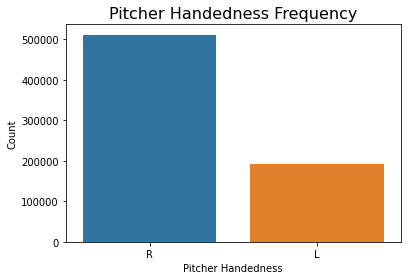

In [29]:
#specfiy axis labels

plot1 = sns.countplot(df['p_throws'])

plt.xlabel('Pitcher Handedness')
plt.ylabel('Count')
plt.title('Pitcher Handedness Frequency', fontsize = 16)

Because pitcher handedness is a feature deemed important for our model, we have to see how it is ditributed aross the dataset. Obviously, RHP dominate well over 2:1 in terms of frequency, which serves as the motivation for including this variable in a model in the first place. However, we have to make sure that this same frequency of pitcher handedness stays constant for any dataset we put into any model. We will take steps to accomplish this later when we preprocess our data.

### Velocity

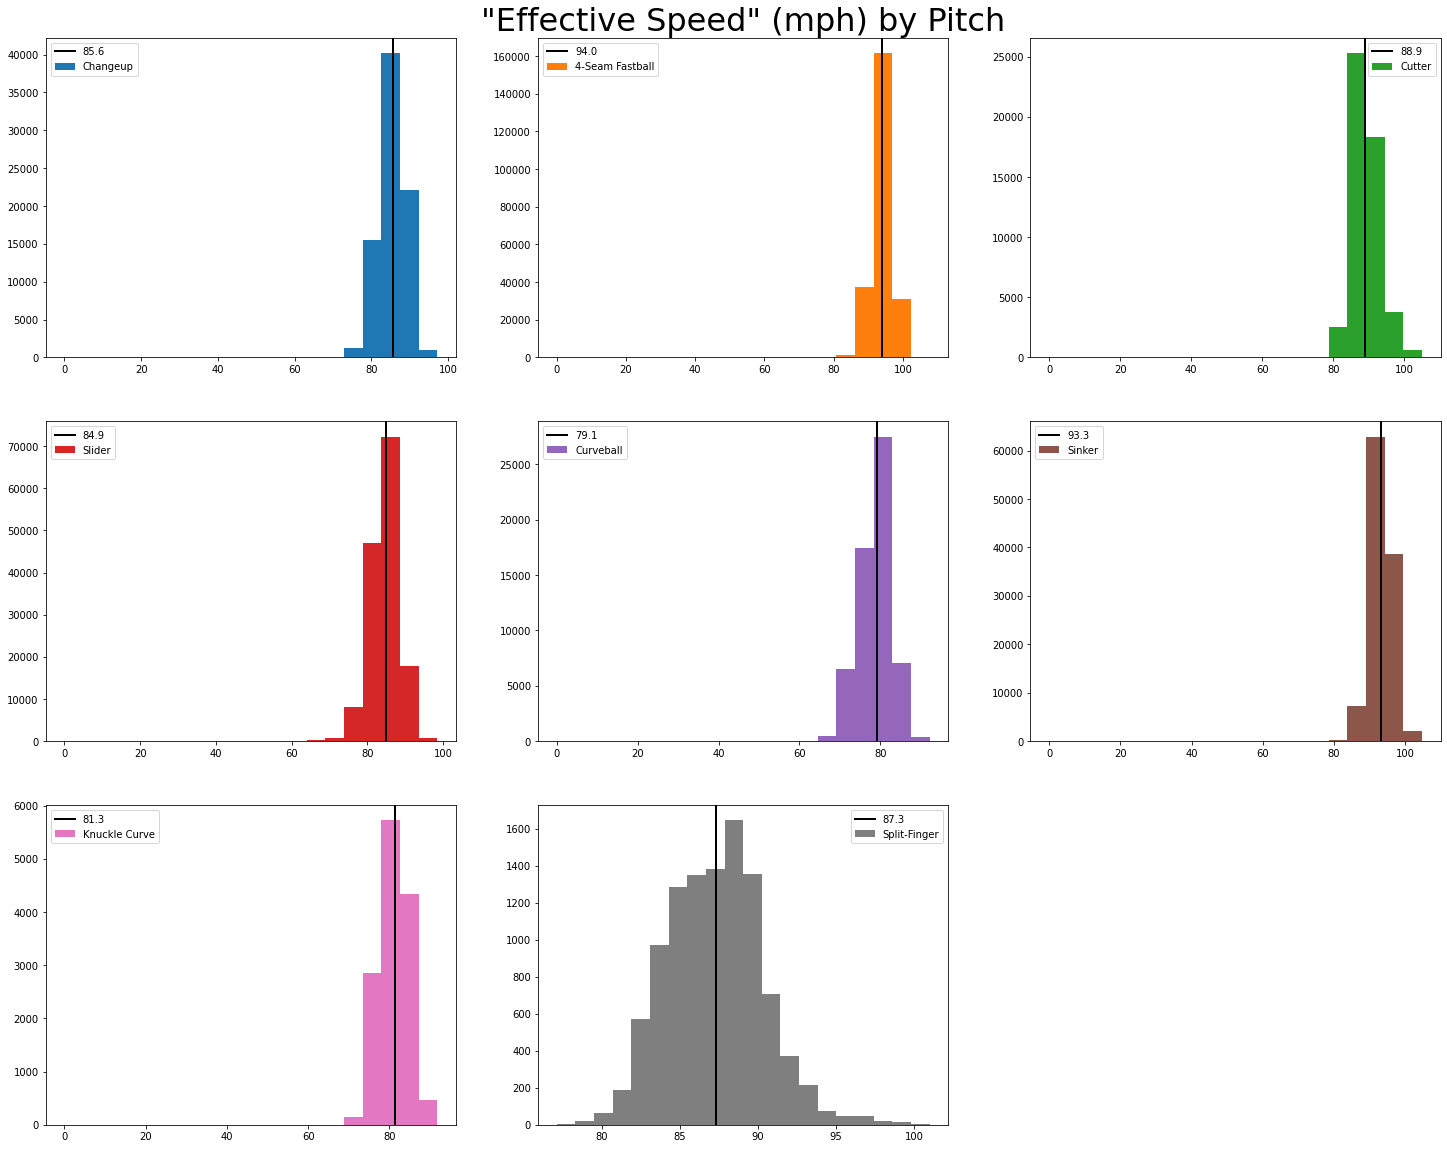

In [30]:
# Generate a pyplot figure
fig = plt.figure(figsize = (25,20))

# Set title
plt.title('"Effective Speed" (mph) by Pitch', fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each unique pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For effective speed (release speed & extension), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  # Iterate to next color in rotation
  c = next(colors)["color"]

  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.effective_speed[df.pitch_name==val]
  
  ax = fig.add_subplot(3, 3, i+1)
  ax.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax.legend()

We now turn to visualizing our data in several contexts. Starting at histograms, we run into a problem when visualizing velocity (effective_speed) by pitch type: Some of the histograms start at 0, which should not happen when visualizing velocity in one dimension. We must filter our dataframe again to include only the instances that have accurate metrics, and redo our histogram.

In [31]:
# Remove all rows with error
num_rows2 = df.shape[0]

# Drop NaN rows and reset indices
df = df[df['effective_speed'] > 60].reset_index(drop = True)

print(df.shape)
print('Number of rows removed:', num_rows2 - df.shape[0])

(704091, 16)
Number of rows removed: 185


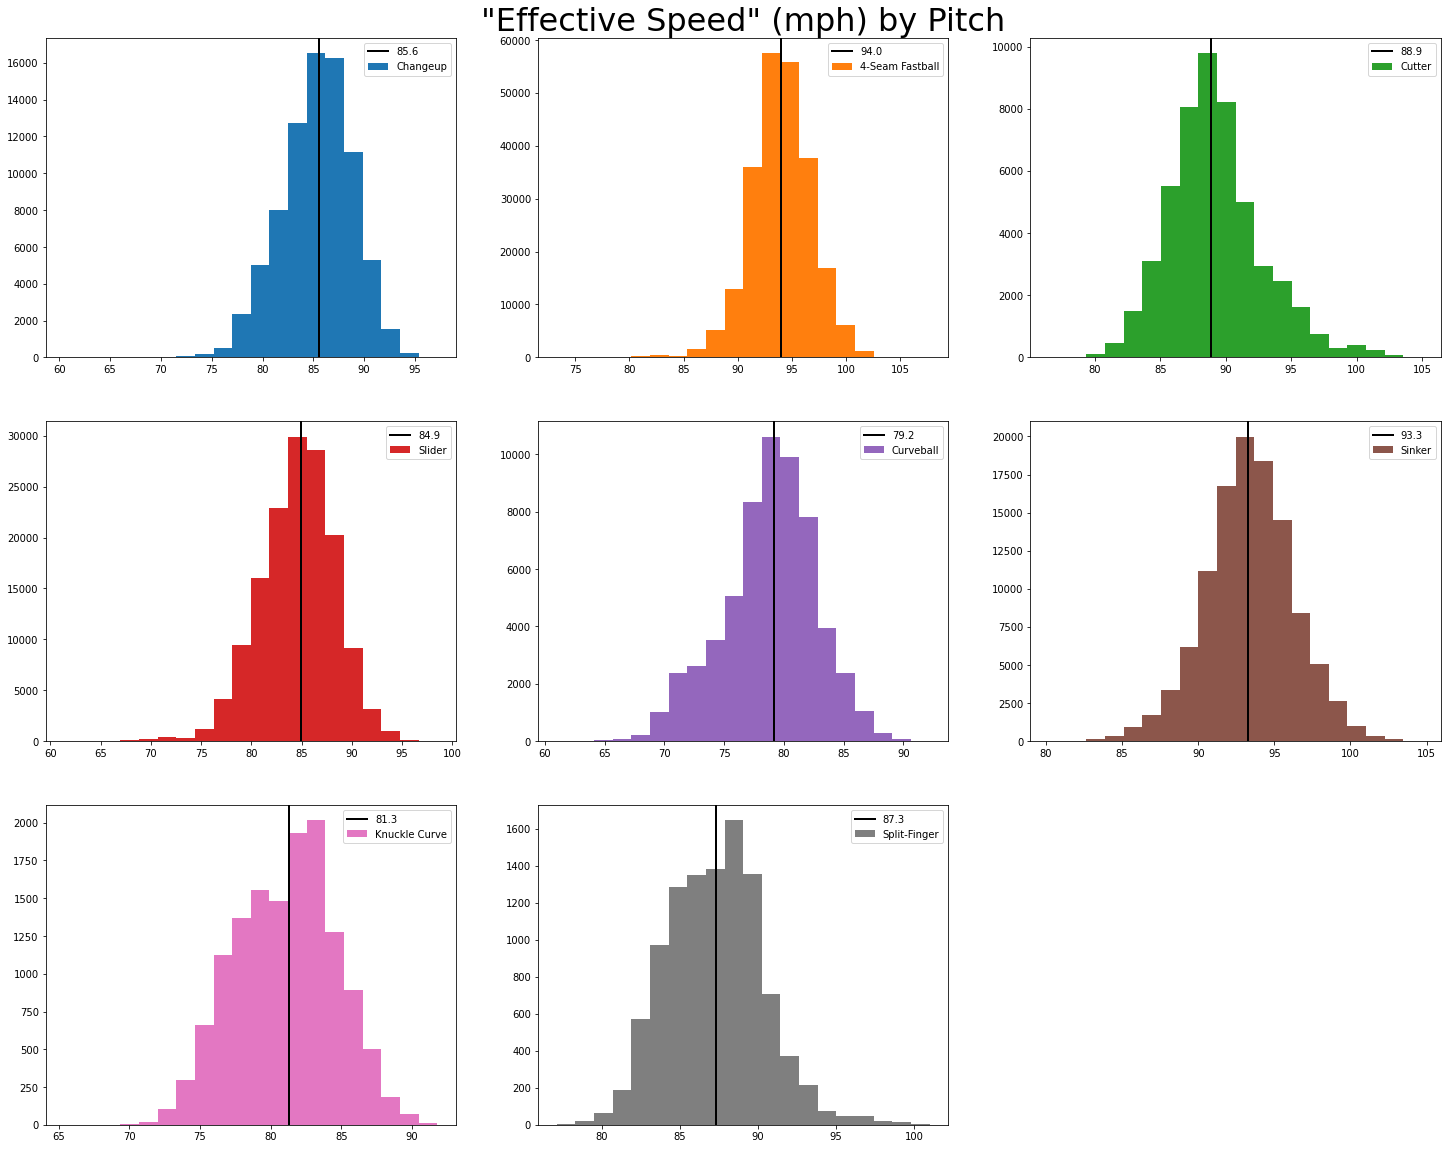

In [32]:
# Generate a pyplot figure
fig = plt.figure(figsize = (25,20))

# Set title
plt.title('"Effective Speed" (mph) by Pitch', fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each unique pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For effective speed (release speed & extension), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  # Iterate to next color in rotation
  c = next(colors)["color"]

  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.effective_speed[df.pitch_name==val]
  
  ax = fig.add_subplot(3, 3, i+1)
  ax.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax.legend()

We can see that the x-axis for some histgorams still begin at 60 mph, which is an arbitrary cut-off point used to eliminate low velocity values in the dataset. After some digging, however, it turns out there are some classified changeups that are thrown less than 80 mph, most belonging to Cleveland reliever Eli Morgan and Nationals pitcher Anibal Sanchez. we feel comfortable exlcuding pitches less than 60 mph to account for Sanchez's "butterfly changeups," as well as to exclude pitches thrown in error. Exhibit A: Bryan Garcia [2].

[2]: MLB Film Room. “Bryan Garcia Ball to Sam Haggerty” Dec 2022, https://www.mlb.com/video/bryan-garcia-ball-to-sam-haggerty-dwvobm?q=Season%20%3D%20%5B2022%5D%20AND%20GameType%20%3D%20%5B%22REGULAR_SEASON%22%5D%20AND%20PitcherHand%20%3D%20%5B%22R%22%5D%20AND%20PitchType%20%3D%20%5B%22CH%22%5D%20AND%20PitchSpeed%20%3D%20%7B%7B%2030%2C%2075%20%7D%7D%20Order%20By%20Timestamp%20DESC&cp=MIXED&p=0

### Spin Rate

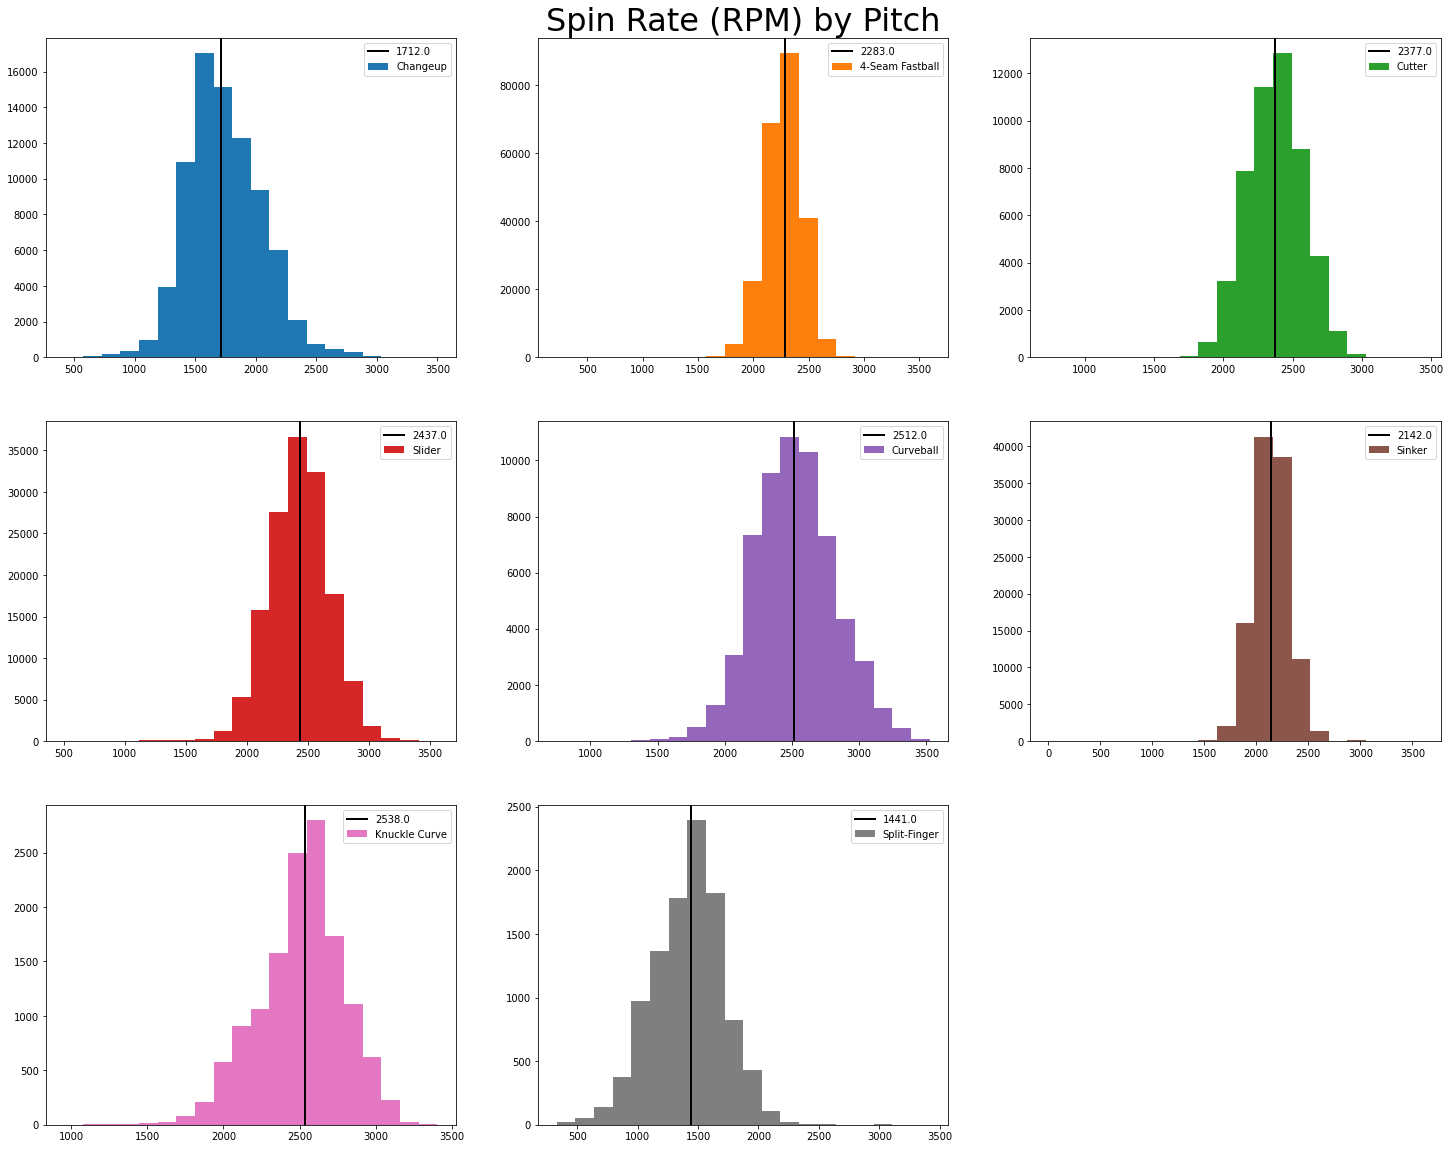

In [33]:
# Generate a pyplot figure
fig2 = plt.figure(figsize = (25,20))

# Set title
plt.title("Spin Rate (RPM) by Pitch", fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each  pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For release spin rate (unit: RPM), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.release_spin_rate[df.pitch_name==val]
  ax2 = fig2.add_subplot(3, 3, i+1)
  ax2.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax2.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax2.legend()

In [34]:
df[df['release_spin_rate'] < 500]

,player_name,p_throws,pitch_name,effective_speed,release_spin_rate,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
55752,"Chapman, Aroldis",L,Split-Finger,92.0,458,110,-0.12677,-130.959916,-6.665825,2.265038,28.698523,-31.735782,0.19,-0.07,0.44,1.04
61859,"Davies, Zach",R,Sinker,88.4,8,256,4.269967,-129.512799,-3.578154,-13.863594,24.851797,-22.649405,-1.15,0.8,-0.63,2.49
103444,"Cruz, Fernando",R,Split-Finger,82.1,420,247,1.320618,-118.19504,-0.871985,-0.477853,22.880589,-29.876999,-0.02,0.25,-0.9,2.59
140252,"Littell, Zack",R,Split-Finger,83.6,409,273,3.60919,-121.117429,-2.22257,-4.061468,21.630859,-34.677561,-0.34,-0.27,-0.81,2.27
140255,"Littell, Zack",R,Split-Finger,84.0,485,266,5.007117,-122.228539,-0.508057,-7.480134,23.224066,-34.998909,-0.65,-0.27,-0.58,3.16
140256,"Littell, Zack",R,Split-Finger,85.2,458,267,2.932242,-123.708191,-0.33387,-7.347854,24.223182,-33.144851,-0.66,-0.08,-1.6,3.47
183031,"Clippard, Tyler",R,Split-Finger,79.3,404,249,1.769415,-116.197842,-5.412607,-2.151007,24.642404,-30.020962,-0.2,0.14,-0.4,0.49
183038,"Clippard, Tyler",R,Split-Finger,79.0,370,247,0.07891,-115.936399,-1.21216,0.732445,23.569968,-30.206473,0.08,0.22,-0.81,2.52
183044,"Clippard, Tyler",R,Split-Finger,79.7,381,255,-1.857686,-117.165522,2.709917,-10.41434,25.155257,-27.859587,-1.19,0.56,-2.77,4.67
183052,"Clippard, Tyler",R,Split-Finger,78.8,422,305,2.472078,-116.053718,-0.037327,-5.022058,26.238861,-35.249495,-0.5,-0.32,-0.11,2.63


In [35]:
# Remove all rows with error
num_rows3 = df.shape[0]

# Drop NaN rows and reset indices
df = df[df['release_spin_rate'] > 500].reset_index(drop = True)

print(df.shape)
print('Number of rows removed:', num_rows3 - df.shape[0])

(704059, 16)
Number of rows removed: 32


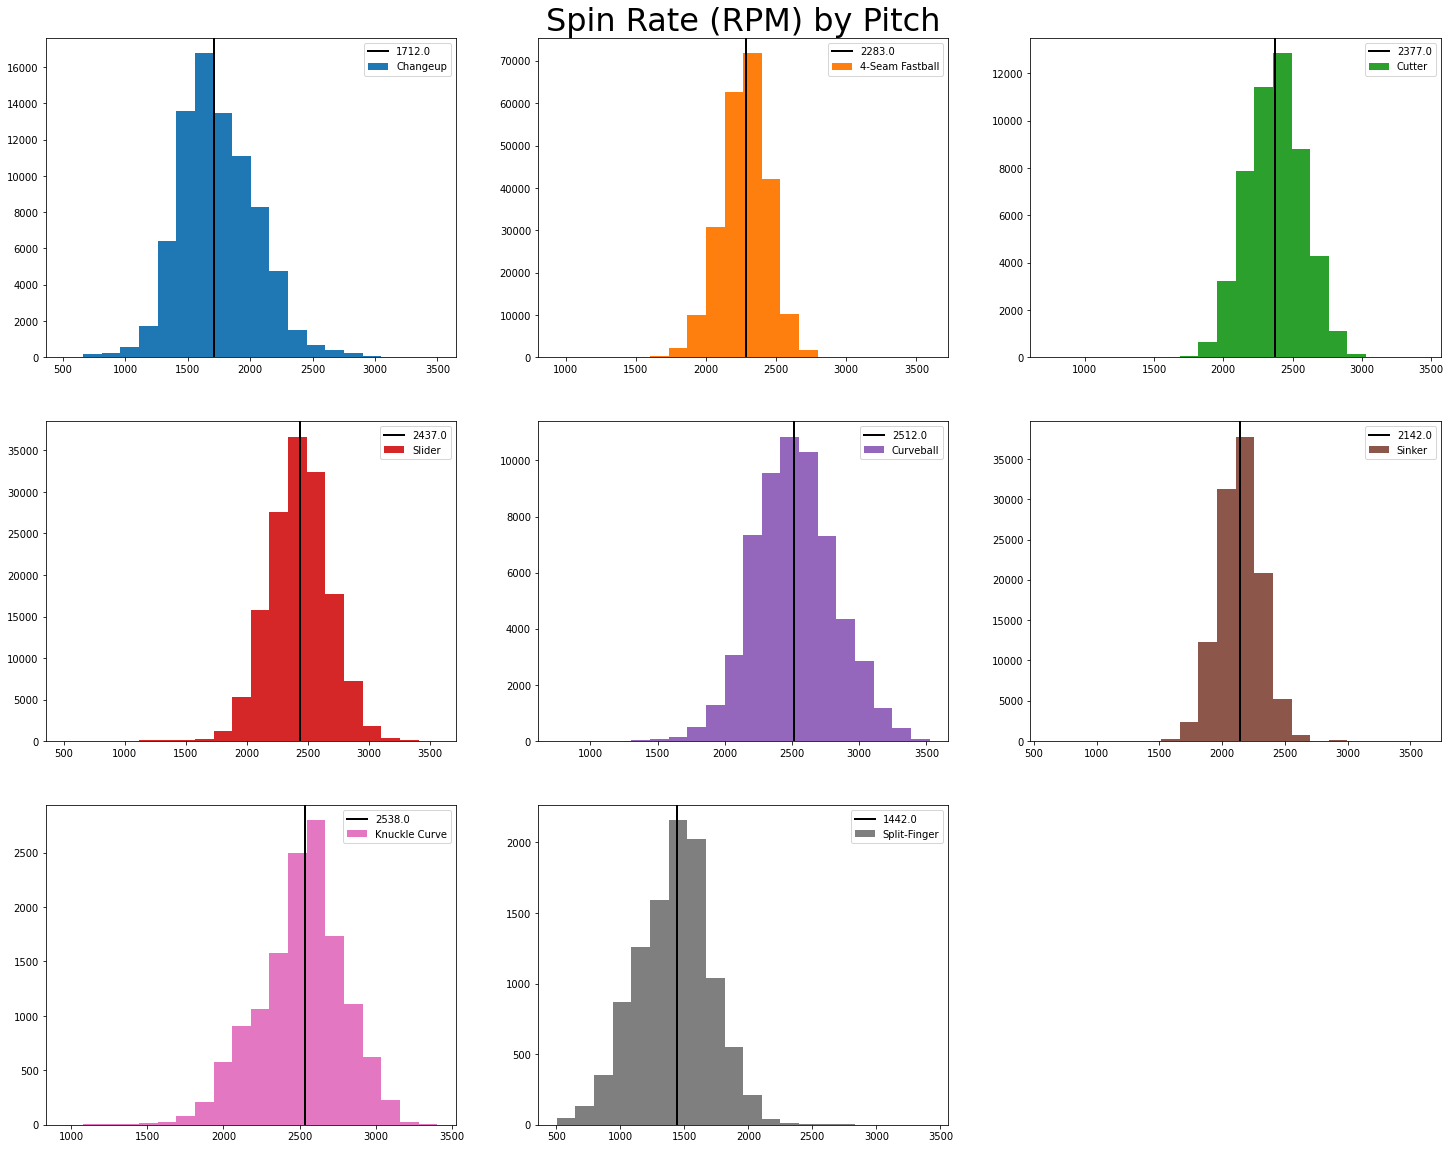

In [36]:
# Generate a pyplot figure
fig2 = plt.figure(figsize = (25,20))

# Set title
plt.title("Spin Rate (RPM) by Pitch", fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each  pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For release spin rate (unit: RPM), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.release_spin_rate[df.pitch_name==val]
  ax2 = fig2.add_subplot(3, 3, i+1)
  ax2.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax2.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax2.legend()

We repeat the same general process with spin rate. We also have low spin rates in some select few instances of the dataset, such as a sinker from Zach Davies with a calculated spin rate of 8. While they are very small in number, they are still worth finding and eliminating to the best extent possible. We chose 500 as a cut-off point to allow for unique pitches such as low-spin changeups, but also as a means to include all of the pitches that intuitiely look like errors on the part of Hawkeye.

### Spin Axis

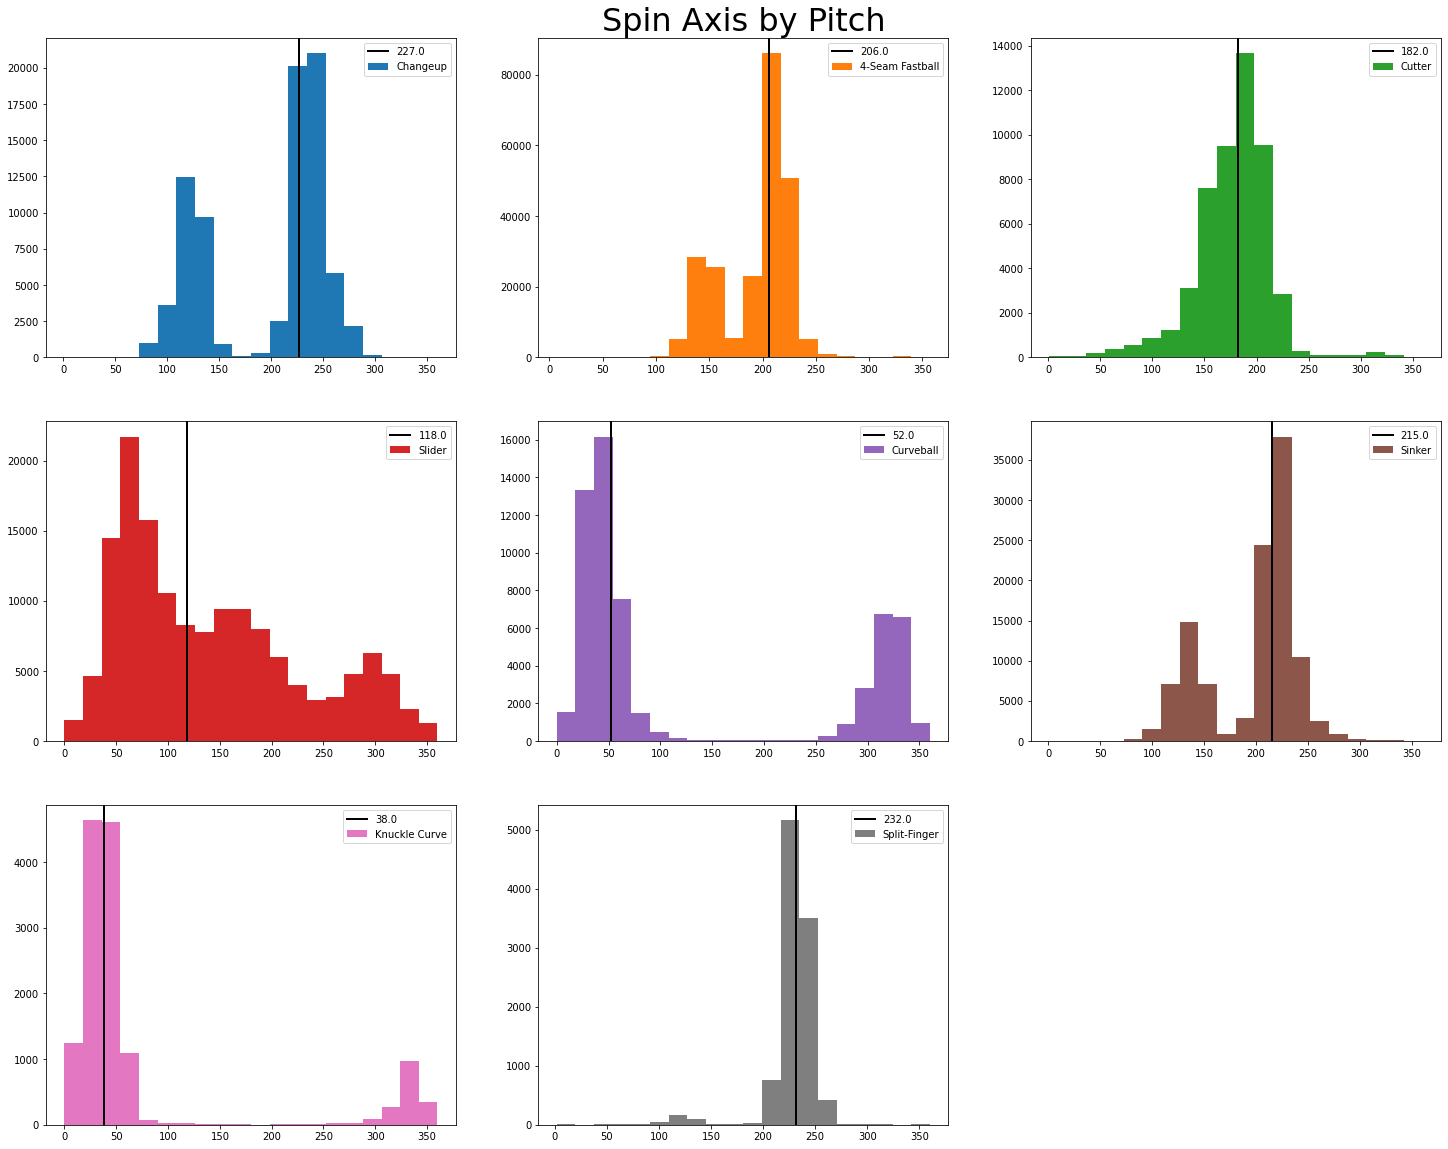

In [37]:
# Generate a pyplot figure
fig3 = plt.figure(figsize = (25,20))

# Set title
plt.title("Spin Axis by Pitch", fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each  pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For release spin rate (unit: RPM), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.spin_axis[df.pitch_name==val]
  ax3 = fig3.add_subplot(3, 3, i+1)
  ax3.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax3.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax3.legend()

In [38]:
df[(df.pitch_name == 'Sinker') & (df.spin_axis < 10)]

,player_name,p_throws,pitch_name,effective_speed,release_spin_rate,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
81057,"Milner, Hoby",L,Sinker,89.3,1766,1,-16.07028,-128.706528,-0.310962,22.590428,24.658605,-32.798928,1.75,-0.04,-0.94,1.75
113337,"Bummer, Aaron",L,Sinker,95.1,2189,4,-3.895302,-138.053031,-1.457349,16.600512,28.381064,-33.292418,1.23,-0.09,1.88,2.33
392474,"Webb, Logan",R,Sinker,94.3,2034,6,4.62831,-136.010662,-2.380798,-13.861258,29.391909,-34.207432,-1.03,-0.19,-0.66,1.49
392503,"Webb, Logan",R,Sinker,95.1,1495,6,5.152394,-138.203083,0.25061,-19.73826,36.481638,-39.824598,-1.45,-0.58,-0.73,2.19
506944,"Milner, Hoby",L,Sinker,88.6,1873,9,-10.508951,-127.56209,1.733954,20.352257,24.201973,-34.28615,1.67,-0.14,1.5,2.6
557078,"McFarland, T.J.",L,Sinker,88.7,1997,6,-7.038765,-130.884118,-3.519029,18.494108,26.758669,-30.431066,1.48,0.11,0.38,2.03
680533,"Webb, Logan",R,Sinker,92.7,2004,7,6.663367,-133.737806,-1.218409,-19.022591,28.815286,-35.176245,-1.47,-0.25,-0.1,2.06


We will choose to leave spin axis alone. A few histograms do have some intrigue, such as the plot for sinkers, but after some exploration the low values of the plot could be explained by the specific pitchers. In particular, side-armers such as Aaron Bummer and Hoby Milner are in this group, which could have something to do with low spin axis values on specific pitches they likely did not execute well. Therefore, we choose to not filter out any pitches on the basis of their spin axis value.

### Pitch Velocity and Acceleration (3D)

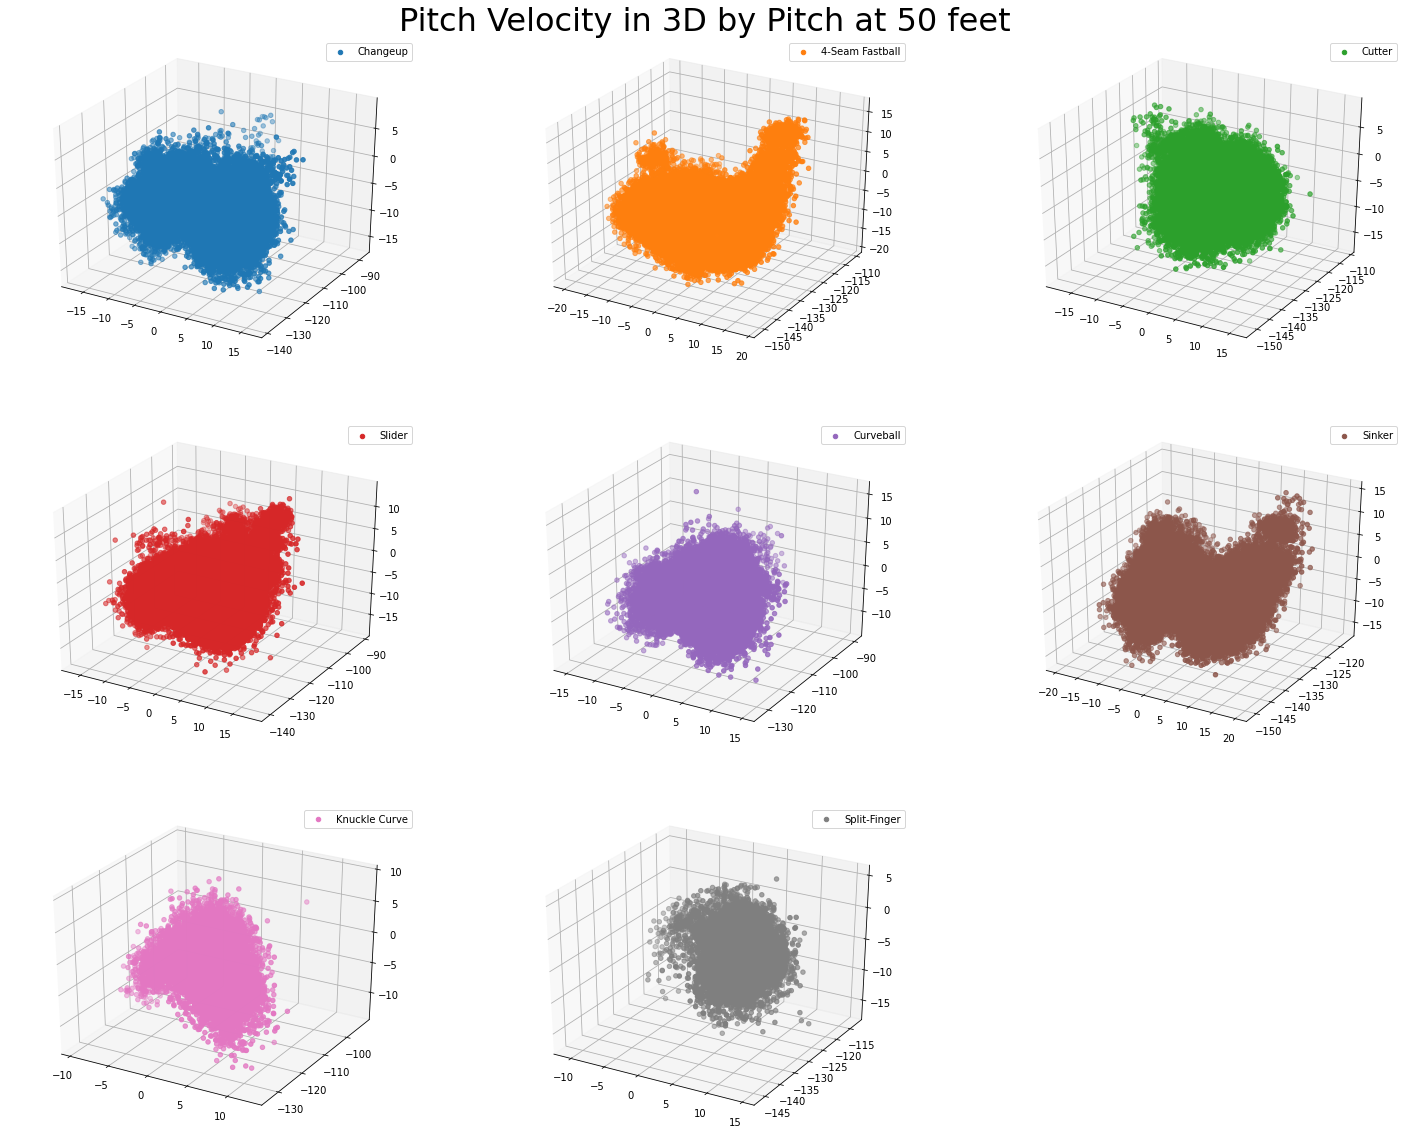

In [39]:
# 3D Scatterplot of Pitch Velocity at x=y=z=50 feet
fig_3D = plt.figure(figsize = (25,20))

# Set title
plt.title("Pitch Velocity in 3D by Pitch at 50 feet", fontsize = 32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

# For velocity in R^3 at 50 feet, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Add 3D subplot to visualize 3D data
  ax_3D = fig_3D.add_subplot(3, 3, i+1, projection='3d')

  # Get 3D data, plot
  x = np.asarray(df.vx0[df.pitch_name==val], dtype= 'float')
  y = np.asarray(df.vy0[df.pitch_name==val], dtype= 'float')
  z = np.asarray(df.vz0[df.pitch_name==val], dtype= 'float')
  
  ax_3D.scatter(x,y,z,label=val, color = c)
  ax_3D.legend()

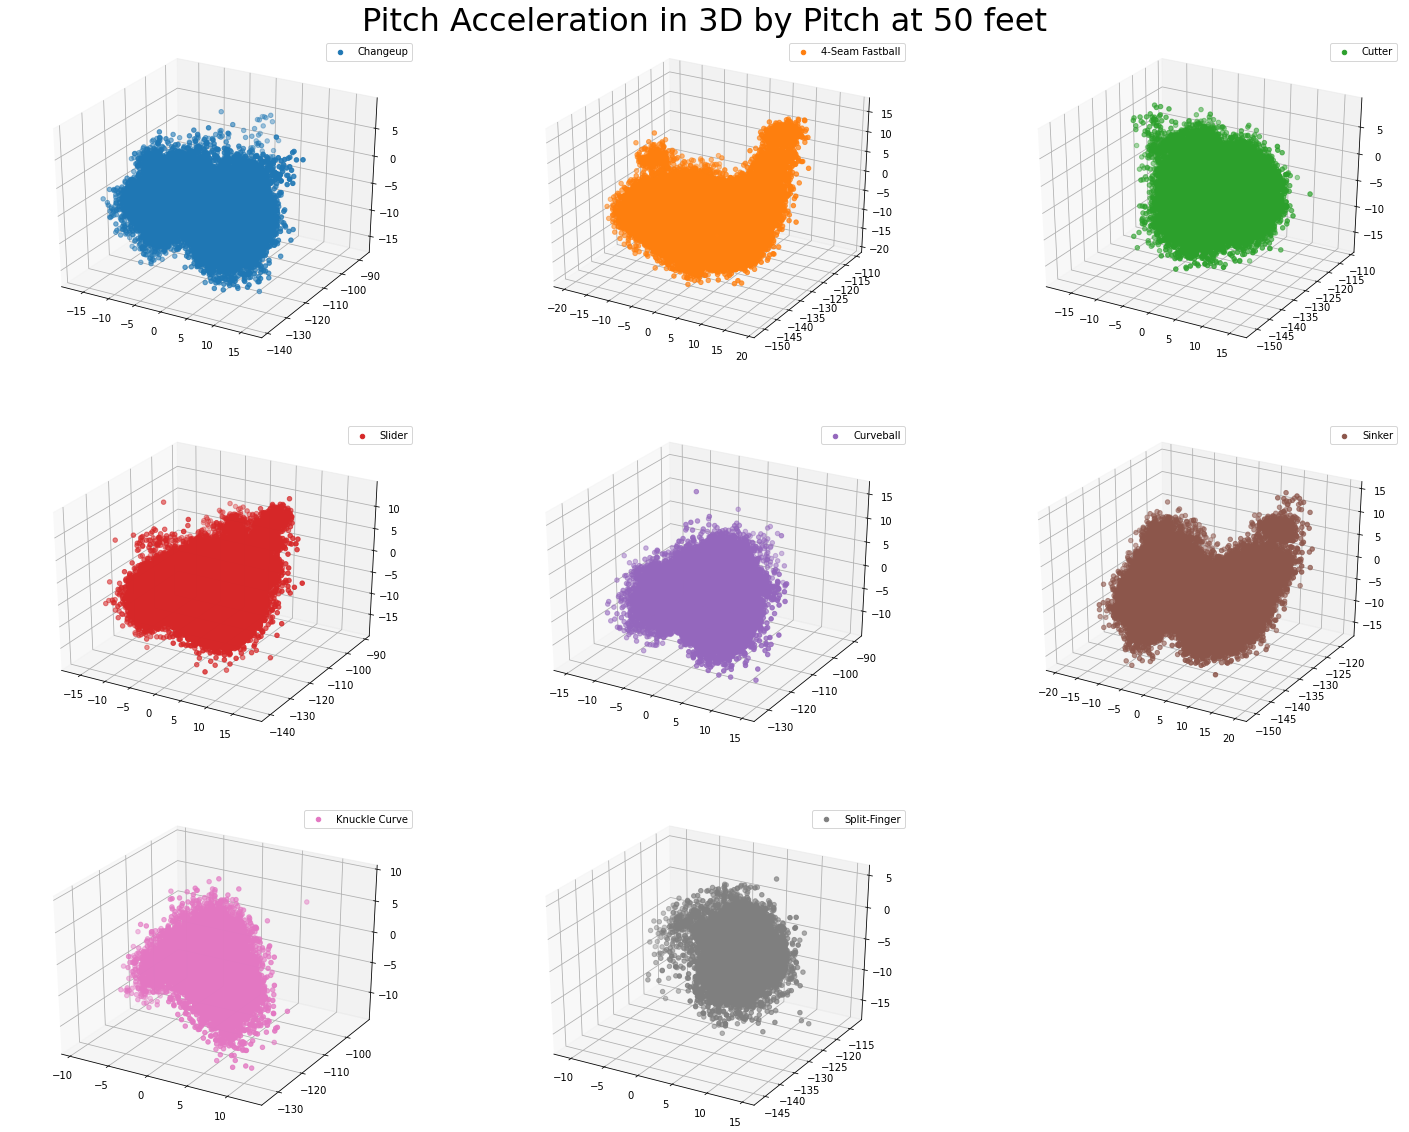

In [40]:
# 3D Scatterplot of Pitch acceleration in x,y,z dimensions at 50 feet
fig2_3D = plt.figure(figsize = (25,20))

# Set title
plt.title("Pitch Acceleration in 3D by Pitch at 50 feet", fontsize=32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

# For each of our variables of interest, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Add a 3D subplot to visualize 3D data
  ax2_3D = fig2_3D.add_subplot(3, 3, i+1, projection='3d')

  # Get 3D data, plot
  x = np.asarray(df.vx0[df.pitch_name==val], dtype= 'float')
  y = np.asarray(df.vy0[df.pitch_name==val], dtype= 'float')
  z = np.asarray(df.vz0[df.pitch_name==val], dtype= 'float')

  ax2_3D.scatter(x,y,z,label=val, color = c)
  ax2_3D.legend()

Some of our first pass features in our dataset are the velocity and acceleration of a pitch in 3 dimensions at 50 feet from the pitcher's release point. Because the dataset is so large, it is likely that for both velocity and acceleration there is too much noise for any significant conclusions to be drawn that warrant including these in a model. Therefore, we can look to elimintate these features as part of a second pass of feature selection.

### Pitch Location and Pitch Movement/Break

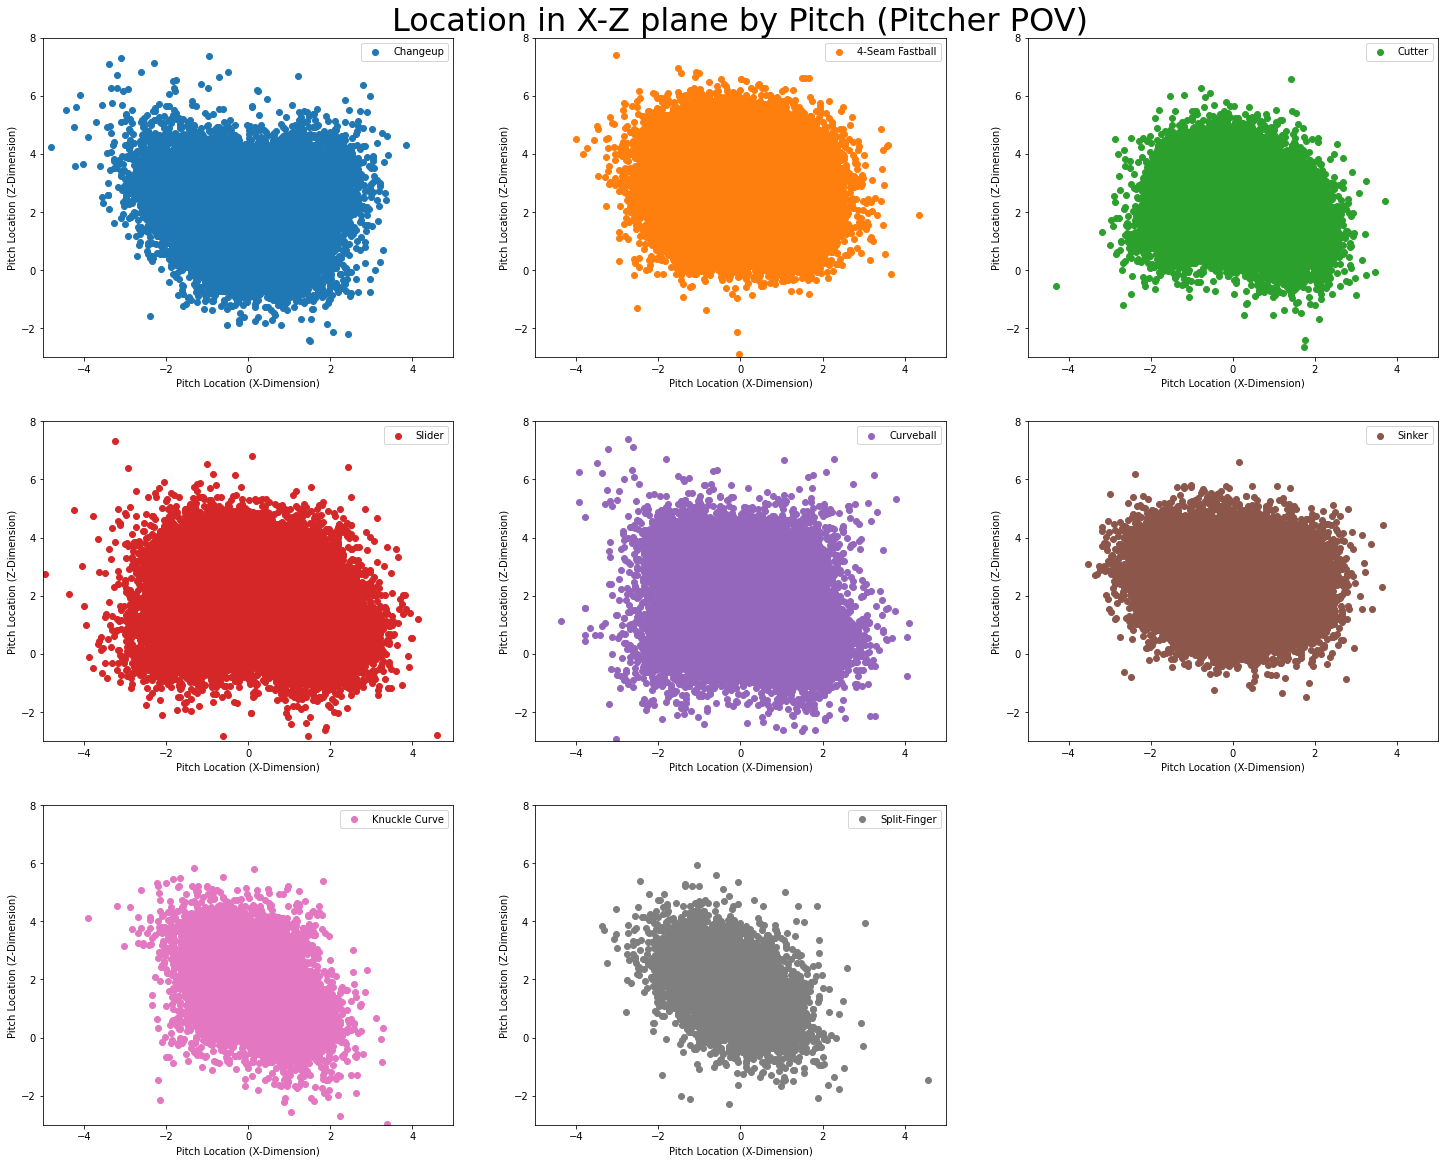

In [41]:
# Plate location plots
fig4 = plt.figure(figsize = (25,20))
plt.title("Location in X-Z plane by Pitch (Pitcher POV)", fontsize=32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  ax4 = fig4.add_subplot(3, 3, i+1)

  x = df.plate_x[df.pitch_name==val]
  y = df.plate_z[df.pitch_name==val]
  
  ax4.scatter(x=x, y=y,label=val, color = c)
  
  ax4.set_xlim(-5, 5)
  ax4.set_ylim(-3, 8)
  ax4.set_xlabel("Pitch Location (X-Dimension)")
  ax4.set_ylabel("Pitch Location (Z-Dimension)")
  ax4.legend()

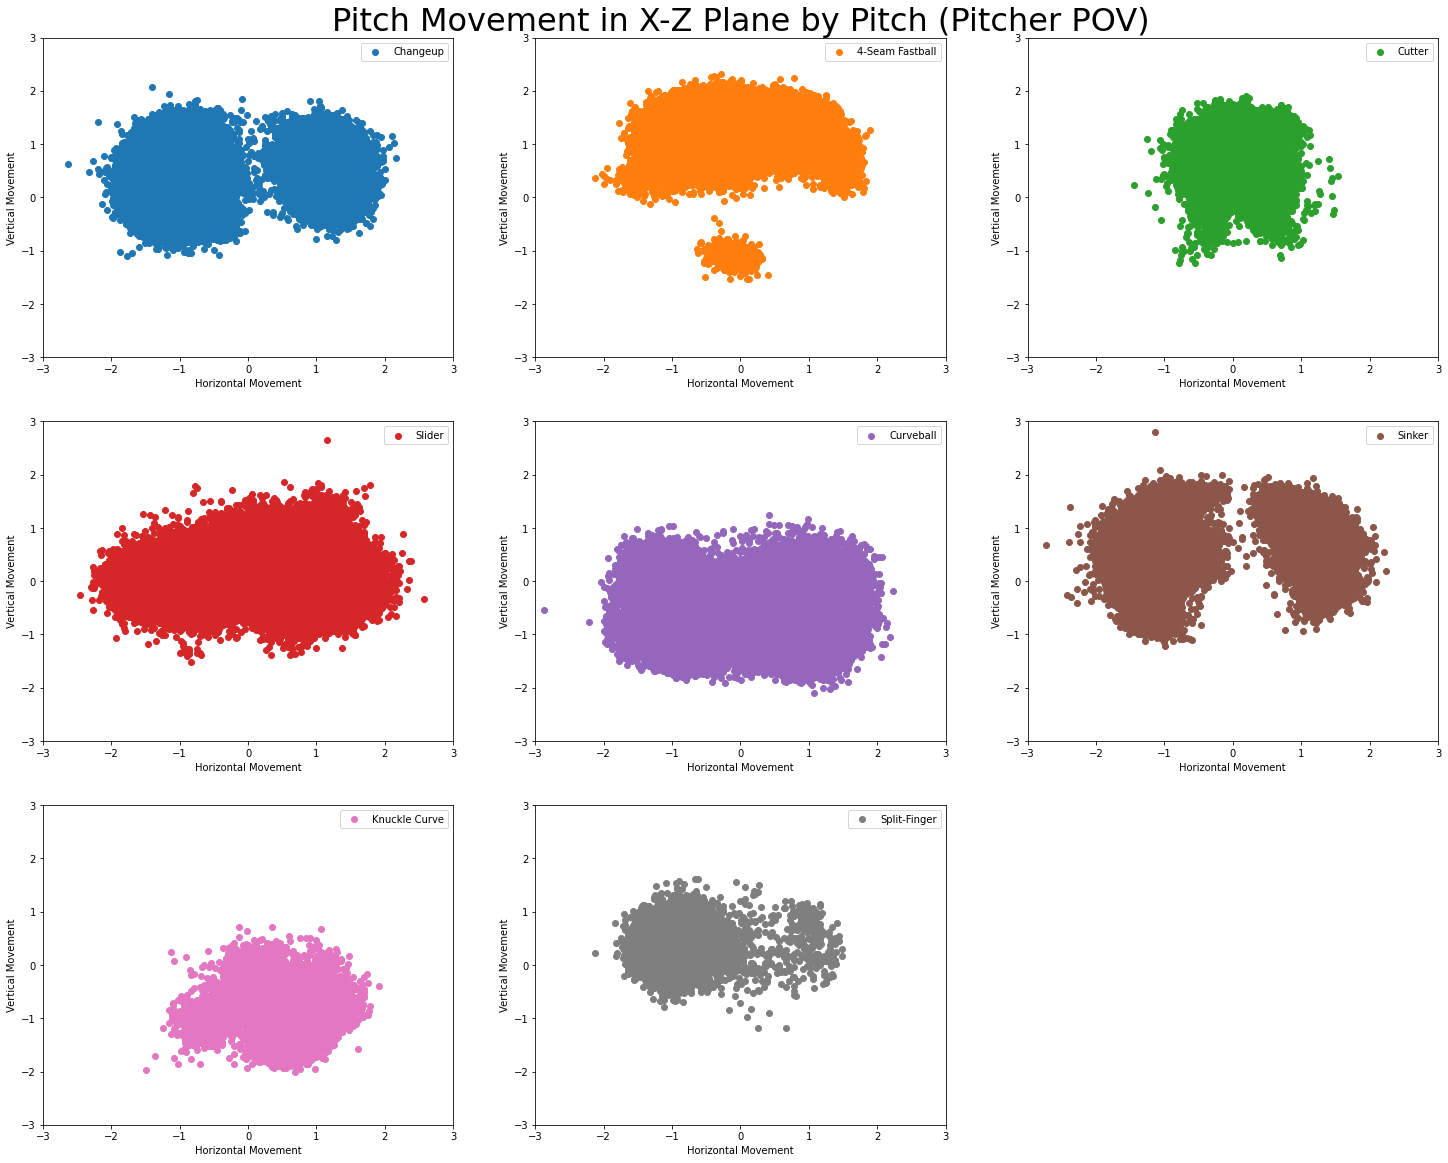

In [42]:
# Pitch movement scatterplots
fig5 = plt.figure(figsize = (25,20))
plt.title("Pitch Movement in X-Z Plane by Pitch (Pitcher POV)", fontsize=32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  ax5 = fig5.add_subplot(3, 3, i+1)

  x = df.pfx_x[df.pitch_name==val]
  y = df.pfx_z[df.pitch_name==val]
  ax5.scatter(x = x,y = y,label=val, color = c)
  
  ax5.set_xlim(-3, 3)
  ax5.set_ylim(-3, 3)
  ax5.set_xlabel("Horizontal Movement")
  ax5.set_ylabel("Vertical Movement")
  ax5.legend()

We now move on to pitch location and pitch movement plots. We first include 2D scatterplots to derive any possible general observations. From the first glance, we definitely see things in pitch movement, with clusters forming in plos for certain pitches such as four-seam fastballs, sinkers, and sliders that stem from pitcher handedness. 

On other hand, we do not see much of any general trend for pitch location. There are general trends in where to try and locate a specific pitch, such as a slider down and away, high and inside fastballs, etc. However, given that this data is from a full season's worth of games amongst 30 teams, there is too much noise in the process of pitching to conclude that preferred pitch zones will map well to actual pitch location. We can therefore also add pitch location metrics to the list of candidates to be discarded in a second pass of feature selection. For now, we will keep all metrics and include them in our first candidate models.

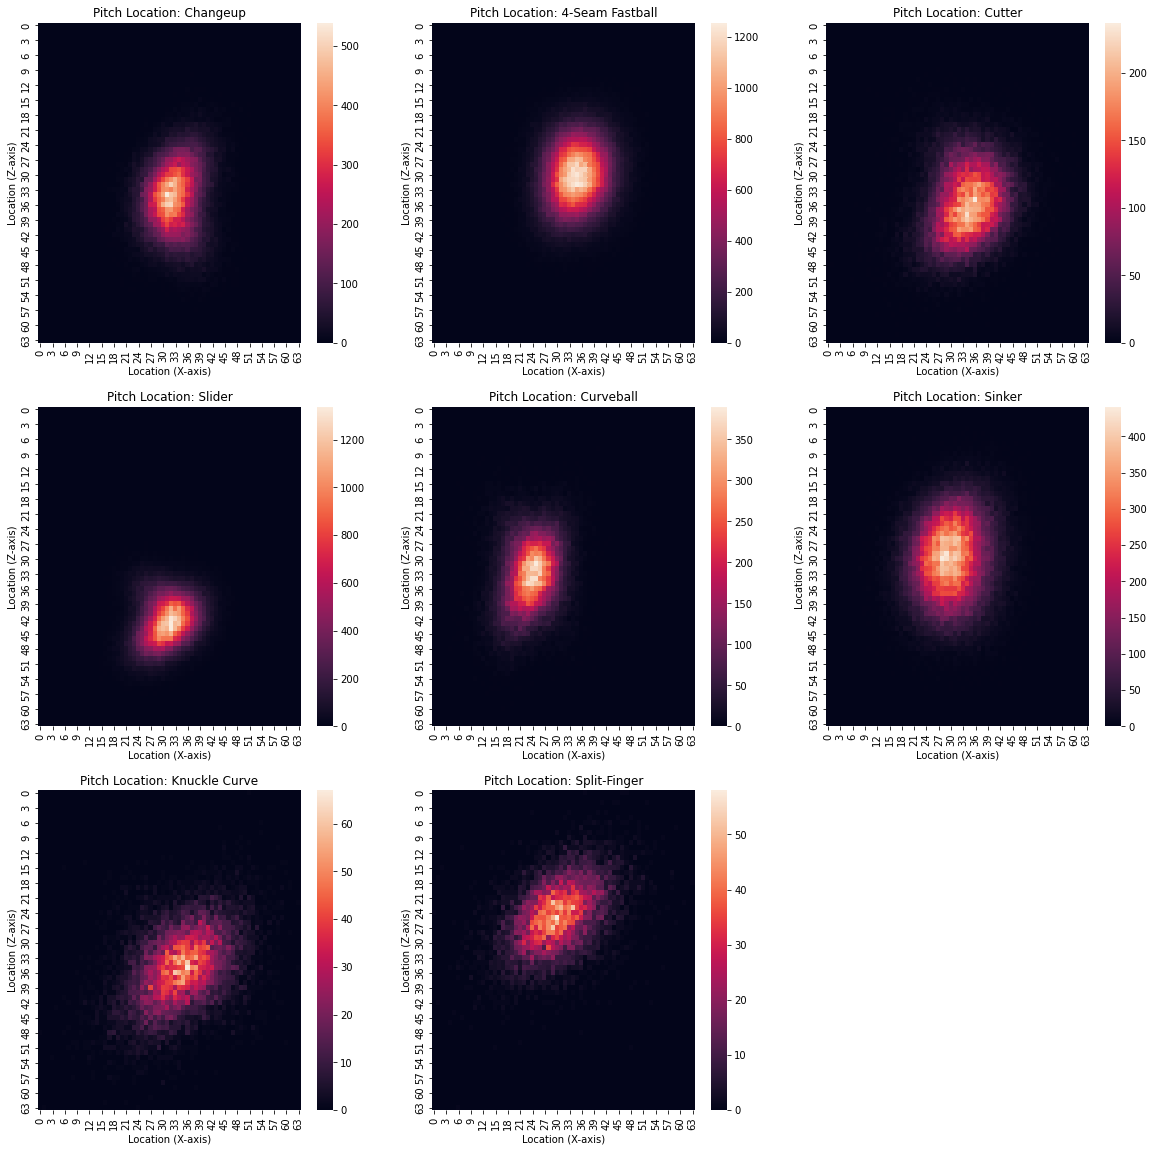

In [43]:
fig6 = plt.figure(figsize = (20,20))

# For each of our variables of interest, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  ax6 = fig6.add_subplot(3, 3, i+1)

  # Generate location data, convert into 2D array as a heatmap
  x = df.plate_x[df.pitch_name==val]
  y = df.plate_z[df.pitch_name==val]

  heatmap, xedges, yedges = np.histogram2d(x, y, bins=(64,64))
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  
  # Plot as heatmap
  sns.heatmap(heatmap)
  ax6.set(title = f"Pitch Location: {val}",
          xlabel = 'Location (X-axis)',
          ylabel = 'Location (Z-axis)')

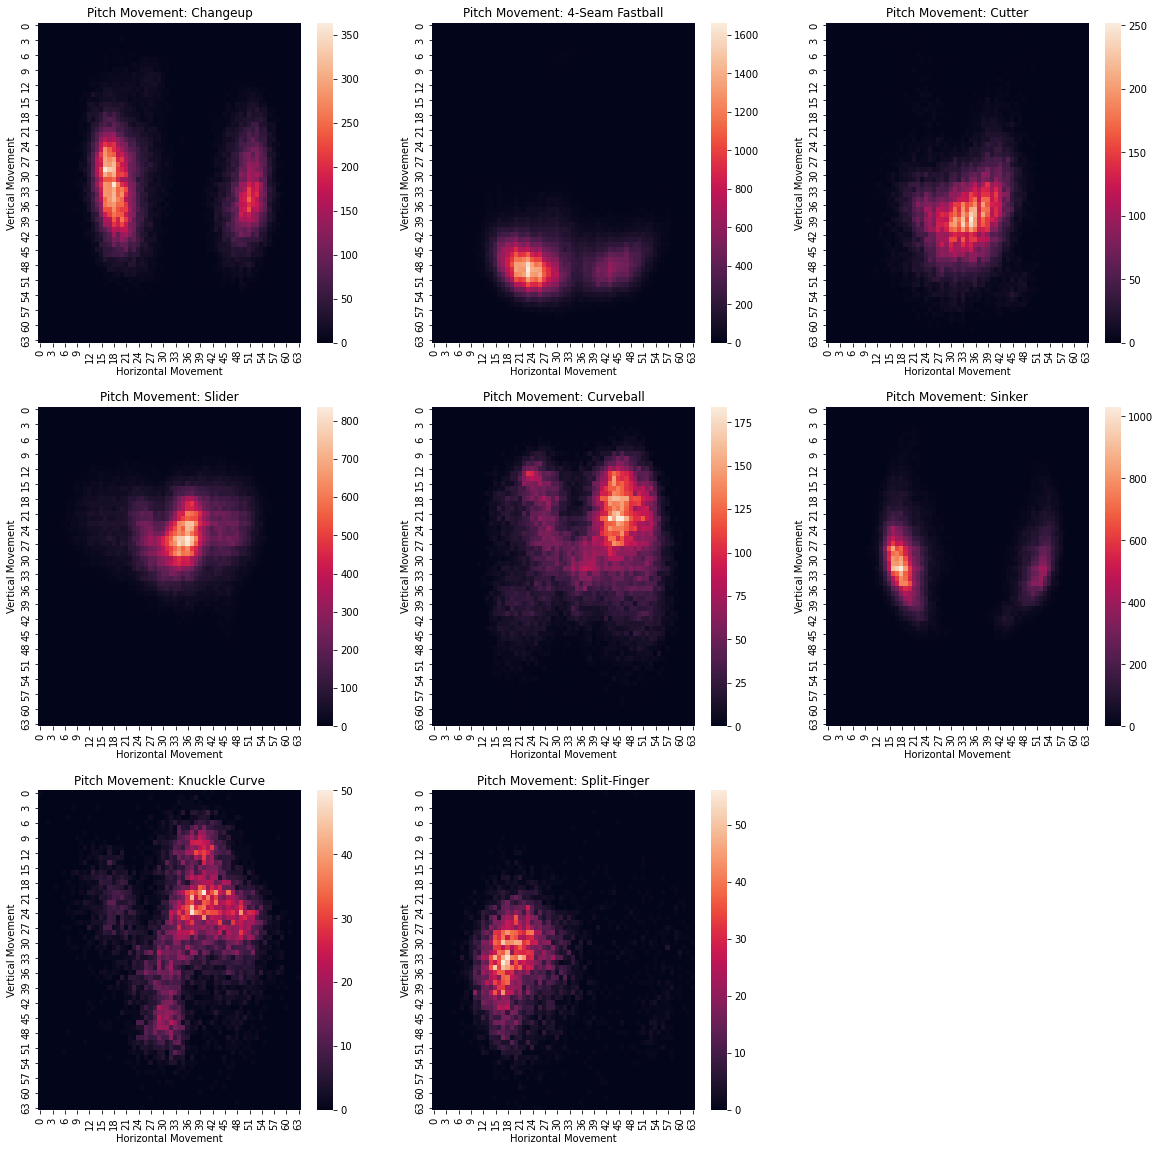

In [44]:
fig7 = plt.figure(figsize = (20,20))

# For each of our variables of interest, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  ax7 = fig7.add_subplot(3, 3, i+1)

  # Generate 3D data, convert to NumPy 2D Array
  # Flipped to match 2D Scatterplot for Movement
  x = df.pfx_x[df.pitch_name==val] 
  y = df.pfx_z[df.pitch_name==val]

  heatmap, xedges, yedges = np.histogram2d(y, x, bins=(64,64))
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  
  # Plot
  sns.heatmap(heatmap)
  ax7.set(title = f"Pitch Movement: {val}",
          xlabel = 'Horizontal Movement',
          ylabel = 'Vertical Movement')



We can see both of these observations made above again by translating these scatterplots into heatmaps. We still get the clusters for horizontal and vertical movement that vary between pitches, but little changes with regards to pitch location. Therefore, it can be concluded that pitch location is not a  unique feature to warrant including in our model, while pitch movement is as there are differences that can be exploited to be used as a feature by which to classify pitches.

## Preprocessing

### Encoding Categorical Columns

Now we can begin moving our dataset into our model with preprocessing. In a classifier, one or more outputs (y) is generated from classifying instances of a dataset based on a set of predictor variables (X). With our pitch classifier, we will be predicitng pitch names based off pitcher handedness, velocity, spin rate, spin axis, and pitch movement.

One of the things that cannot be used in a model is a categorical variable. More specifically, a categorical variable cannot be inputted to a model as a string; it must be encoded as a number. For pitcher handedness, we can do this very easily with a LabelEncoder() object that will encode L and R into binary categories of 0 and 1 (not respectively).

In [45]:
df = df.drop(['player_name'], axis = 1)
df

,p_throws,pitch_name,effective_speed,release_spin_rate,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,R,Changeup,81.5,1771,213,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.8,-0.32,2.24
1,R,4-Seam Fastball,98.1,2434,189,2.238826,-142.091777,-8.96856,-2.851911,33.061824,-8.887788,-0.17,1.58,0.1,2.59
2,R,Changeup,85.2,1856,212,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,R,4-Seam Fastball,97.5,2258,192,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.3
4,R,Cutter,86.7,2348,127,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.0,0.36,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704054,R,Split-Finger,93.8,1314,234,2.903163,-133.823709,-4.599003,-4.20002,23.66655,-30.580581,-0.3,0.08,-0.89,2.05
704055,R,Slider,88.6,2440,92,1.715667,-126.691081,-4.680738,11.802514,22.704431,-25.935414,1.11,0.51,-0.64,1.74
704056,R,4-Seam Fastball,100.7,2320,207,10.013029,-144.212678,-7.642544,-1.416227,28.775681,-19.306867,0.04,0.81,1.53,1.84
704057,R,4-Seam Fastball,99.9,2164,206,4.033907,-142.625616,-7.606169,0.276497,27.659035,-16.289654,0.08,1.06,-0.62,2.01


In [46]:
pitch_names = df.pitch_name

In [47]:
# Encode the categorical variable of pitcher handedness
label_encoder = LabelEncoder()    

df_pro = df

df_pro['p_throws'] = label_encoder.fit_transform(df_pro['p_throws'])
df_pro

,p_throws,pitch_name,effective_speed,release_spin_rate,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,1,Changeup,81.5,1771,213,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.8,-0.32,2.24
1,1,4-Seam Fastball,98.1,2434,189,2.238826,-142.091777,-8.96856,-2.851911,33.061824,-8.887788,-0.17,1.58,0.1,2.59
2,1,Changeup,85.2,1856,212,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,1,4-Seam Fastball,97.5,2258,192,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.3
4,1,Cutter,86.7,2348,127,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.0,0.36,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704054,1,Split-Finger,93.8,1314,234,2.903163,-133.823709,-4.599003,-4.20002,23.66655,-30.580581,-0.3,0.08,-0.89,2.05
704055,1,Slider,88.6,2440,92,1.715667,-126.691081,-4.680738,11.802514,22.704431,-25.935414,1.11,0.51,-0.64,1.74
704056,1,4-Seam Fastball,100.7,2320,207,10.013029,-144.212678,-7.642544,-1.416227,28.775681,-19.306867,0.04,0.81,1.53,1.84
704057,1,4-Seam Fastball,99.9,2164,206,4.033907,-142.625616,-7.606169,0.276497,27.659035,-16.289654,0.08,1.06,-0.62,2.01


In [48]:
df_pro.dtypes

p_throws               int64
pitch_name            object
effective_speed      Float64
release_spin_rate      Int64
spin_axis              Int64
vx0                  Float64
vy0                  Float64
vz0                  Float64
ax                   Float64
ay                   Float64
az                   Float64
pfx_x                Float64
pfx_z                Float64
plate_x              Float64
plate_z              Float64
dtype: object

Checking all of our predictor variables, we now see all are a numeric type. We must now do the same with regards to our output variable because the output of a model cannot be a string for a classified pitch, so we must encode each pitch into a number with another LabelEncoder() object.

For any practical purposes, we must be able to keep track of which pitch is classified as what number to be able to convert the output number from a model back into a string that gives us the name of the classified pitch.

In [49]:
df_pro['pitch_name']

0                Changeup
1         4-Seam Fastball
2                Changeup
3         4-Seam Fastball
4                  Cutter
               ...       
704054       Split-Finger
704055             Slider
704056    4-Seam Fastball
704057    4-Seam Fastball
704058    4-Seam Fastball
Name: pitch_name, Length: 704059, dtype: object

In [50]:
# Encode pitches into numerical categories
label_encoder2 = LabelEncoder()

df_pro['pitch_name'] = label_encoder2.fit_transform(df_pro['pitch_name'])
df_pro

,p_throws,pitch_name,effective_speed,release_spin_rate,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,1,1,81.5,1771,213,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.8,-0.32,2.24
1,1,0,98.1,2434,189,2.238826,-142.091777,-8.96856,-2.851911,33.061824,-8.887788,-0.17,1.58,0.1,2.59
2,1,1,85.2,1856,212,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,1,0,97.5,2258,192,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.3
4,1,3,86.7,2348,127,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.0,0.36,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704054,1,7,93.8,1314,234,2.903163,-133.823709,-4.599003,-4.20002,23.66655,-30.580581,-0.3,0.08,-0.89,2.05
704055,1,6,88.6,2440,92,1.715667,-126.691081,-4.680738,11.802514,22.704431,-25.935414,1.11,0.51,-0.64,1.74
704056,1,0,100.7,2320,207,10.013029,-144.212678,-7.642544,-1.416227,28.775681,-19.306867,0.04,0.81,1.53,1.84
704057,1,0,99.9,2164,206,4.033907,-142.625616,-7.606169,0.276497,27.659035,-16.289654,0.08,1.06,-0.62,2.01


### Sampling Datasets

Since we will first build primarily quick-and-dirty models, we do not require such a large dataset as the one we have until with the exception of the Random Forest Classifier. Therefore, we want to build a function that, when we call it, can give us a sample dataset from our larger dataset that allows us to build a quick and dirty model off of. 

These sample datasets must also be created via stratified sampling on pitcher handedness and pitch name. In essence, the frequency of RHP and LHP, as well as all unique pitches we can classify must be preserved across all of our sample datasets that are converted into training and test data.

To begin, we can first define a check function taht allows us to see the frequency of pitches in a dictionary. I prefer to use this stratified sampling method found on Statology to accomplish the stratified sampling from our larger dataset [3].


[3]: Statology. “Stratified Sampling in Pandas (With Examples).” September 3 2020, Accessed Dec 26 2022, https://www.statology.org/stratified-sampling-pandas/.

---



#### Standardization
One more important part of preprocessing is standardization, where in order to avoid skewing of results, our dataset is normalized to itself in order to be of the same scale as all of the other features in the dataset. This will be done within our function, and we achieve this with a StandardScaler() object that brings all of our predictor variables to the same scale.



In [51]:
'''
Goal: Check the frequency of each encoded pitch in the dataset.
      
      Gets total number of pitches, divides absolute frequencies for all pitches
      to get proportionate frequency of all pitches
--------------------------------------------------------------------------------
Inputs: Counter object (will be sorted by number encoding)
Returns: dictionary, holds encoded pitches and its % frequency in the dataset
         (sorted by dictionary key)
'''
def to_freq_dict(counter):
  ret_di = {}

  counter_total = sum(i[1] for i in counter)
  
  for i in counter:
    ret_di[i[0]] = round((i[1] / counter_total) * 100 , 1)

  return ret_di

In [52]:
'''
Goal: Take a large dataset, take a stratified sample of size N and split into
      predictor variables (X) and output variable (y)
--------------------------------------------------------------------------------
Inputs: dataset (df), n (int)
Returns: X and y dataframes
'''
def sample_dataset(dataset, n):
  N = n

  #perform stratified random sampling
  sample_set = dataset.groupby(['p_throws','pitch_name'], group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(dataset))))).sample(frac=1).reset_index(drop=True)

  # Sort into predictor variables (X) and output variable (y)
  X = sample_set.drop(['pitch_name'], axis=1)
  y = sample_set['pitch_name']

  return X, y

In [53]:
'''
Goal: Take a large dataset split into its predictor variables (X) and output (y), 
      return a standardized train_test_split data
--------------------------------------------------------------------------------
Inputs: x_df, y_df
Returns: four datasets, akin to train_test_split() function's output but smaller
'''

def preprocess(x_df, y_df):
  # Split into training and test data
  X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size = 0.2, random_state=0, stratify = y_df) 

  # Checks: proper train_test_split and stratified sampling done correctly
  '''
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

  pitch_freq = to_freq_dict(sorted(Counter(y).items(), key=itemgetter(0)))
  y_train_freq = to_freq_dict(sorted(Counter(y_train).items(), key=itemgetter(0)))
  y_test_freq = to_freq_dict(sorted(Counter(y_test).items(), key=itemgetter(0)))

  print(pitch_freq)
  print(y_train_freq)
  print(y_test_freq)
  '''

  # Scale training and test data for predictor variables
  scaler = StandardScaler()  

  X_train = scaler.fit_transform(X_train)  
  X_test = scaler.transform(X_test)  

  return X_train, X_test, y_train, y_test

To check if our stratified sampling function works throughout our model construction, will create a frequency table for pitches in our larger dataset as a template by which to compare the performance of the above function with. We will recall this as we go along building each model to check.

In [54]:
# Gives a dataframe for each pitch, what number they are encoded to, and their frequency
pitch_df = pd.DataFrame()
pitch_df['label'] = pitch_names
pitch_df['encoded'] = df_pro['pitch_name'].tolist()
pitch_encoded = round(pitch_df.value_counts(sort=False, ascending=False) / len(df_pro) * 100, 1)

pitch_encoded

label            encoded
4-Seam Fastball  0          33.0
Changeup         1          11.4
Curveball        2           8.4
Cutter           3           7.2
Knuckle Curve    4           1.9
Sinker           5          15.8
Slider           6          20.9
Split-Finger     7           1.5
dtype: float64

Now that our models are ready to be created, we will start by creating and evaluating four candidate models: Naive Bayes, K-Nearest Neighbors, Decision Tree, and Random Forest.

We will run each on standard parameters first before later fine-tuning.

# Model Testing

With our dataset preprocessed, proprely encoded, and standardized, we are ready to go. Since we will first do quick model fitting, we will run all four of our candidate models on default parameters. We will then run each through a function that fits to its own unique sample dataset, predicts on test data and generates confusion matrices to visualize the types of errors it creates, both in absolute and realtive terms. Finally, we will return its accuracy ratings for training and test data, and view its classification report if precision and recall, returning its overall F1 score.

For easier access, we will also provide a dataframe that will store all of the performance metrics for the models we create.

## Functions

In [55]:
performance_df = pd.DataFrame(columns=['Model', 'Test_Accuracy', 'Training_Accuracy', 'F1 Score', 'Model_Accuracy'])

In [56]:
def confusion_matrix_plots(model_name, pred, y_test_set):
  # Create confusion matrix: view the 
  # Adding up each row is the actual number of instances per class,
  # Adding up each column is the predicted number of instances per class

  conf_matrix = confusion_matrix(pred, y_test_set)

  # Create confusion matrix in plot for better visualization
  fig, ax = plt.subplots(1, 2, figsize=(20,20))
  # matshow command: turn array of nested arrays (i.e. matrix) into a matrix plot
  ax[0].matshow(conf_matrix, cmap=plt.cm.coolwarm, alpha=0.3)

  # For loop 1: loops over each row of the matrix
  for i in range(conf_matrix.shape[0]):
      # For loop 2: loops through each value in each matrix row, adds value in text to matrix plot
      for j in range(conf_matrix.shape[1]):
          ax[0].text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
  
  ax[0].set_xlabel('Predictions', fontsize=18)
  ax[0].set_ylabel('Actuals', fontsize=18)
  ax[0].set_title(f'Confusion Matrix {model_name}', fontsize=20)


  # Normalizes matrix, replaces absolute number of errors per class to
  # proportion of errors per class

  # Note: normalization is done due to the differrent frequency for each class (aka pitch)
  rows= conf_matrix.sum(axis = 1, keepdims = True)
  normalized_matrix = conf_matrix / rows

  # Diagonals fill for 0% error when predicting each class correctly
  np.fill_diagonal(normalized_matrix, 0)
  normalized_matrix = np.round_(normalized_matrix, 4)

  # Create confusion matrix in plot for better visualization
  # matshow command: turn array of nested arrays (i.e. matrix) into a matrix plot
  ax[1].matshow(normalized_matrix, cmap=plt.cm.autumn, alpha=0.3)


  # For loop 1: loops over each row of the matrix
  for i in range(normalized_matrix.shape[0]):
    # For loop 2: loops through each value in each matrix row, adds value in text to matrix plot
    for j in range(normalized_matrix.shape[1]):
      ax[1].text(x=j, y=i,s=normalized_matrix[i, j], va='center', ha='center', size='medium')
  
  ax[1].set_xlabel('Predictions', fontsize=18)
  ax[1].set_ylabel('Actuals', fontsize=18)
  ax[1].set_title(f'Normalized Confusion Matrix {model_name}', fontsize=18)

In [57]:
def quick_model(model, model_name, x_dataset, y_dataset):
  X = x_dataset
  y = y_dataset

  X_train, X_test, y_train, y_test = preprocess(X, y)
  # Fit model and predict
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)


  confusion_matrix_plots(model_name, pred= y_pred, y_test_set = y_test)
  
  # Provides scores for testing and training sets
  print("")
  
  test_score = model.score(X_test, y_test)
  train_score = model.score(X_train, y_train)

  print(f"{model_name} Testing set accuracy: ", test_score, '\n')
  print(f"{model_name} Training set accuracy: ", train_score, '\n')

  print(classification_report(y_test, y_pred), '\n')

  y_cv_pred = cross_val_predict(model, X_train, y_train, cv=5)
  model_f1 = f1_score(y_train, y_cv_pred, average="macro")

  print(f"{model_name} F1 Score", model_f1, '\n')
  
  scores = cross_val_score(model, X, y, cv = 3)
  model_accuracy = np.mean(scores)
  print('Model (average) accuracy: ', model_accuracy)

  performance_df.loc[len(performance_df)] = [model_name, test_score, train_score, model_f1, model_accuracy]

##Naive Bayes

In [58]:
NB = GaussianNB()

X_nb, y_nb = sample_dataset(df_pro, 100000)


Naive Bayes Testing set accuracy:  0.7251 

Naive Bayes Training set accuracy:  0.719975 

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      6595
           1       0.71      0.43      0.54      2273
           2       0.65      0.62      0.64      1686
           3       0.53      0.63      0.57      1437
           4       0.29      0.54      0.37       384
           5       0.80      0.71      0.76      3155
           6       0.81      0.68      0.74      4177
           7       0.19      0.92      0.32       293

    accuracy                           0.73     20000
   macro avg       0.61      0.68      0.60     20000
weighted avg       0.77      0.73      0.74     20000
 

Naive Bayes F1 Score 0.5984228054149833 

Model (average) accuracy:  0.7204500367437227


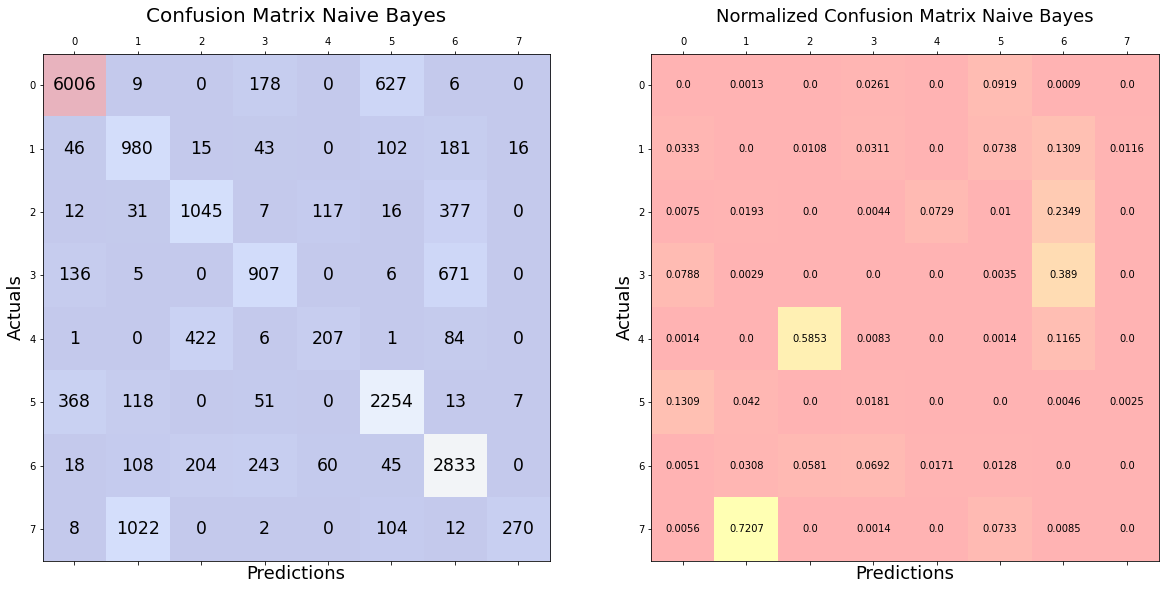

In [59]:
quick_model(NB, 'Naive Bayes', X_nb, y_nb)

## K-Nearest Neighbors

In [60]:
KNN = KNeighborsClassifier()

X_knn, y_knn = sample_dataset(df_pro, 100000)


K-Nearest Neighbors Testing set accuracy:  0.86085 

K-Nearest Neighbors Training set accuracy:  0.9024625 

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      6595
           1       0.88      0.92      0.90      2273
           2       0.79      0.81      0.80      1686
           3       0.70      0.63      0.67      1437
           4       0.64      0.40      0.49       384
           5       0.88      0.85      0.87      3155
           6       0.84      0.87      0.85      4177
           7       0.64      0.37      0.47       293

    accuracy                           0.86     20000
   macro avg       0.79      0.73      0.75     20000
weighted avg       0.86      0.86      0.86     20000
 

K-Nearest Neighbors F1 Score 0.74010705142027 

Model (average) accuracy:  0.8165200230630734


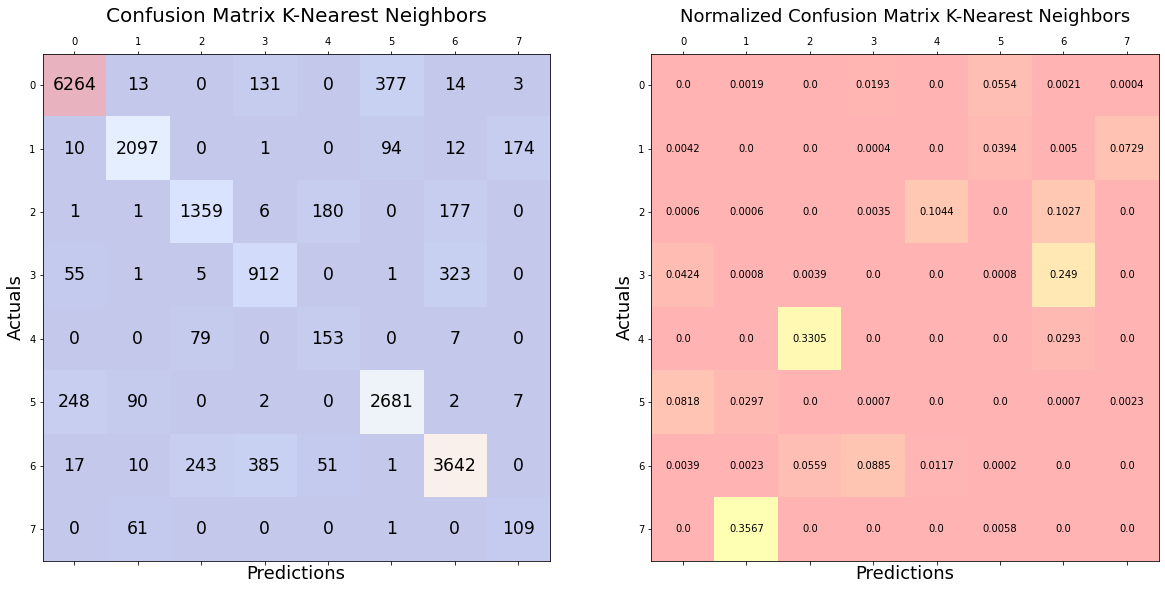

In [61]:
quick_model(KNN, 'K-Nearest Neighbors', X_knn, y_knn)

## Decision Tree

In [62]:
tree = DecisionTreeClassifier()

X_tree, y_tree = sample_dataset(df_pro, 100000)


Decision Tree Testing set accuracy:  0.80705 

Decision Tree Training set accuracy:  1.0 

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      6595
           1       0.85      0.85      0.85      2273
           2       0.71      0.72      0.72      1686
           3       0.55      0.55      0.55      1437
           4       0.41      0.43      0.42       384
           5       0.83      0.83      0.83      3155
           6       0.79      0.78      0.79      4177
           7       0.45      0.44      0.45       293

    accuracy                           0.81     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.81      0.81      0.81     20000
 

Decision Tree F1 Score 0.6897331283161847 

Model (average) accuracy:  0.8075399941615663


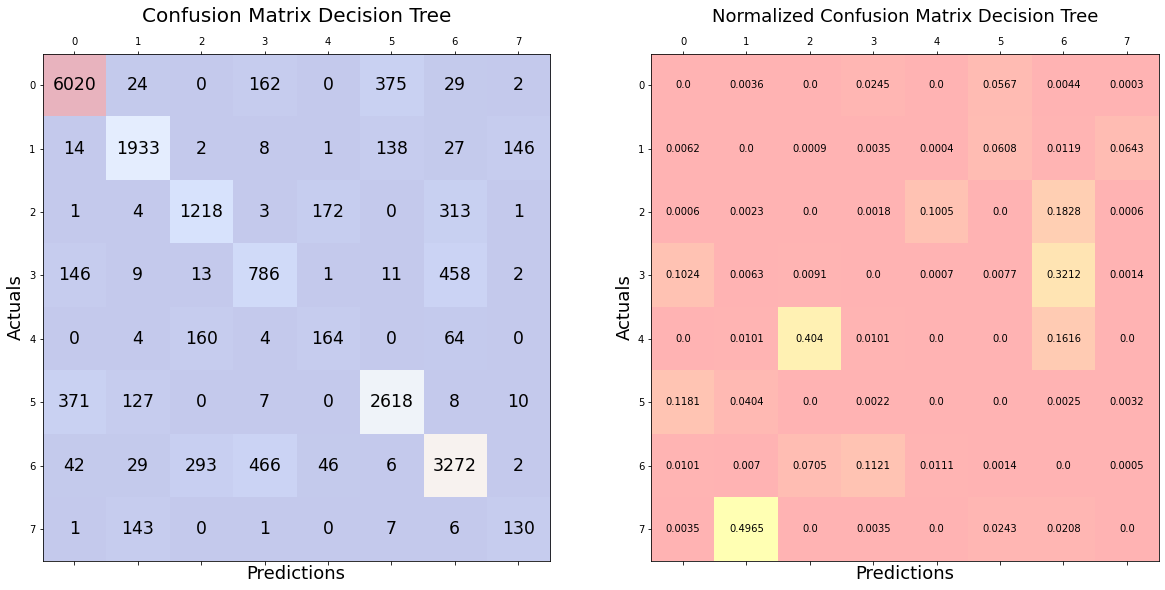

In [63]:
quick_model(tree, "Decision Tree", X_tree, y_tree)

## Random Forest Classifier

In [64]:
len(df_pro)

704059

In [65]:
# Default Estimators = 100, criterion = 'gini'
rfc = RandomForestClassifier(n_jobs = -1)

X_rfc, y_rfc = sample_dataset(df_pro, len(df_pro))


Random Forest Testing set accuracy:  0.8942206630116751 

Random Forest Training set accuracy:  0.99998934747988 

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     46437
           1       0.91      0.94      0.93     16005
           2       0.84      0.83      0.84     11871
           3       0.78      0.67      0.72     10115
           4       0.83      0.49      0.62      2703
           5       0.93      0.90      0.91     22213
           6       0.85      0.91      0.88     29407
           7       0.80      0.50      0.61      2061

    accuracy                           0.89    140812
   macro avg       0.86      0.78      0.81    140812
weighted avg       0.89      0.89      0.89    140812
 

Random Forest F1 Score 0.80365667290841 

Model (average) accuracy:  0.8928072790641081


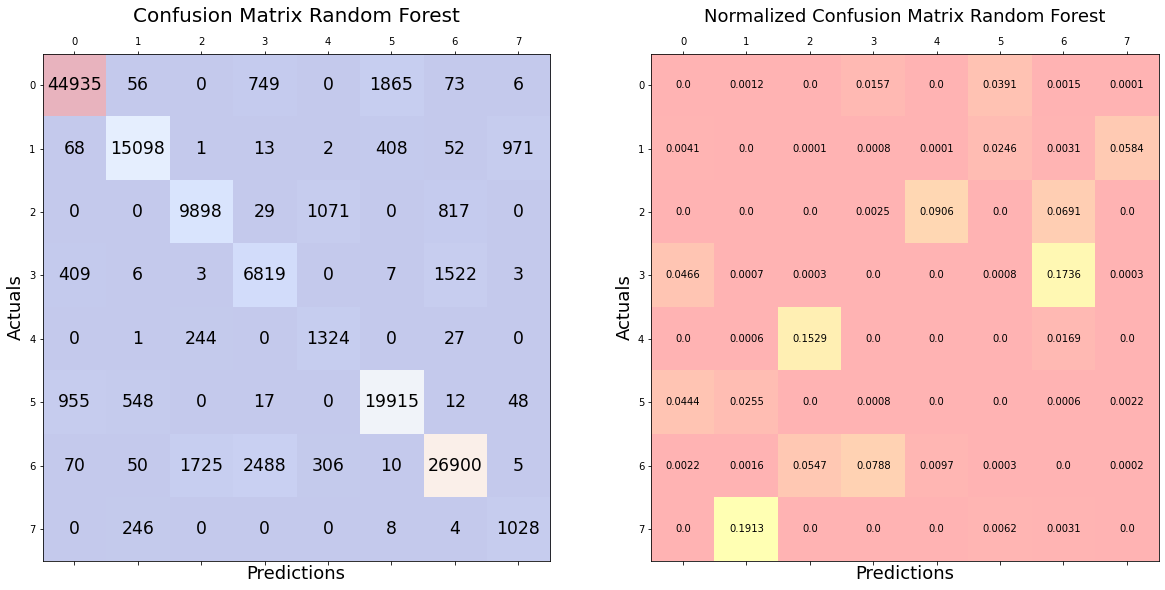

In [66]:
quick_model(rfc, "Random Forest", X_rfc, y_rfc)

## Findings

In [67]:
performance_df

,Model,Test_Accuracy,Training_Accuracy,F1 Score,Model_Accuracy
0,Naive Bayes,0.725100,0.719975,0.598423,0.720450
1,K-Nearest Neighbors,0.860850,0.902462,0.740107,0.816520
2,Decision Tree,0.807050,1.000000,0.689733,0.807540
3,Random Forest,0.894221,0.999989,0.803657,0.892807


In [68]:
pitch_encoded

label            encoded
4-Seam Fastball  0          33.0
Changeup         1          11.4
Curveball        2           8.4
Cutter           3           7.2
Knuckle Curve    4           1.9
Sinker           5          15.8
Slider           6          20.9
Split-Finger     7           1.5
dtype: float64

From looking at all of the confusion matrices for each of our four models, we can list some commonalities between them:
*   The three largest pockets of errors are curveballs predicted as knuckle-curves, changeups predicted as splitters, and sliders predicted as cutters. Also worth noting is that there was some error in the other direction for each combination, though not nearly to the same extent.
*   In general, the largest spread of errors are sliders, with many misclassified as curveballs, knuckle-curves, and cutters. Even the Naive Bayes model classified over 10% of sliders as changeups.
*   About 80% of four-seams were classified correctly, with the rest going to the other two fastball variants. 


In terms of accuracy on the testing set and the model's overall F1 score, the ranking from lowest to highest are:
* Naive Bayes -> Decision Tree -> K-Nearest Neighbors -> Random Forest Classifier

It is also worth noting that the training set's accuracy from our Decision Tree and Random Forest Classifiers is at or near 1.0, or 100%. In other words, our Decision Tree and Random Forest Classifiers have overfit their training sets.

Let's look at Precision and Recall more closely, viewing their rankings for the model as a whole. For both metrics, the models rank in the same order. There are some interesting variation in precision and recall by individual pitch.
*   Naive Bayes has lowest precision and recall in knuckle-curves and splitters, in fact prioritizing recall over precision from the widely distant values for both metrics.
*   KNN improves upon Naive Bayes, but still maintains lower precision recall in the same two pitches plus cutters.
*  The Decision Tree classifier performs similar to KNN, but with slightly lower values.
*  The Random Forest classifier performs best across nearly all pitches with much higher precision and recall. Interestingly, however, knuckle-curves and splitters both have recall just under 50%, but very high precision.










# Fine-Tuning

## Feature Selection (Second Pass)

With visualizations of our first pass features done and our first models created, the conclusions we have drawn can now inform us about a second pass of feature selection. 


To recall, because of the amount of noise in our visualizations and the excessive amount of time taken to run each model, we no longer have no use for the features associated with pitch location, as well as pitch velocity and acceleration in three dimensions at 50 feet from the pitcher. These features (8) can now be safely eliminated from our dataset and model. We can now redo our models one more time to see how eliminating these features affect the model's overall performance. 

In [69]:
# Drop columns with axis 1
df_pro2 = df_pro.drop(["vx0","vy0","vz0",	"ax",	"ay",	"az", "plate_x",	"plate_z"], axis = 1)
df_pro2

,p_throws,pitch_name,effective_speed,release_spin_rate,spin_axis,pfx_x,pfx_z
0,1,1,81.5,1771,213,-1.34,0.8
1,1,0,98.1,2434,189,-0.17,1.58
2,1,1,85.2,1856,212,-1.22,0.83
3,1,0,97.5,2258,192,-0.13,1.74
4,1,3,86.7,2348,127,0.63,0.0
...,...,...,...,...,...,...,...
704054,1,7,93.8,1314,234,-0.3,0.08
704055,1,6,88.6,2440,92,1.11,0.51
704056,1,0,100.7,2320,207,0.04,0.81
704057,1,0,99.9,2164,206,0.08,1.06


## Second Pass Models

###Naive Bayes

In [70]:
NB = GaussianNB()

X_nb2, y_nb2 = sample_dataset(df_pro2, 100000)


Naive Bayes 2 Testing set accuracy:  0.7327 

Naive Bayes 2 Training set accuracy:  0.7300875 

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      6595
           1       0.73      0.50      0.60      2273
           2       0.68      0.66      0.67      1686
           3       0.51      0.53      0.52      1437
           4       0.36      0.34      0.35       384
           5       0.78      0.68      0.73      3155
           6       0.75      0.71      0.73      4177
           7       0.22      0.84      0.35       293

    accuracy                           0.73     20000
   macro avg       0.61      0.65      0.61     20000
weighted avg       0.75      0.73      0.74     20000
 

Naive Bayes 2 F1 Score 0.6047530932743859 

Model (average) accuracy:  0.7298500080458895


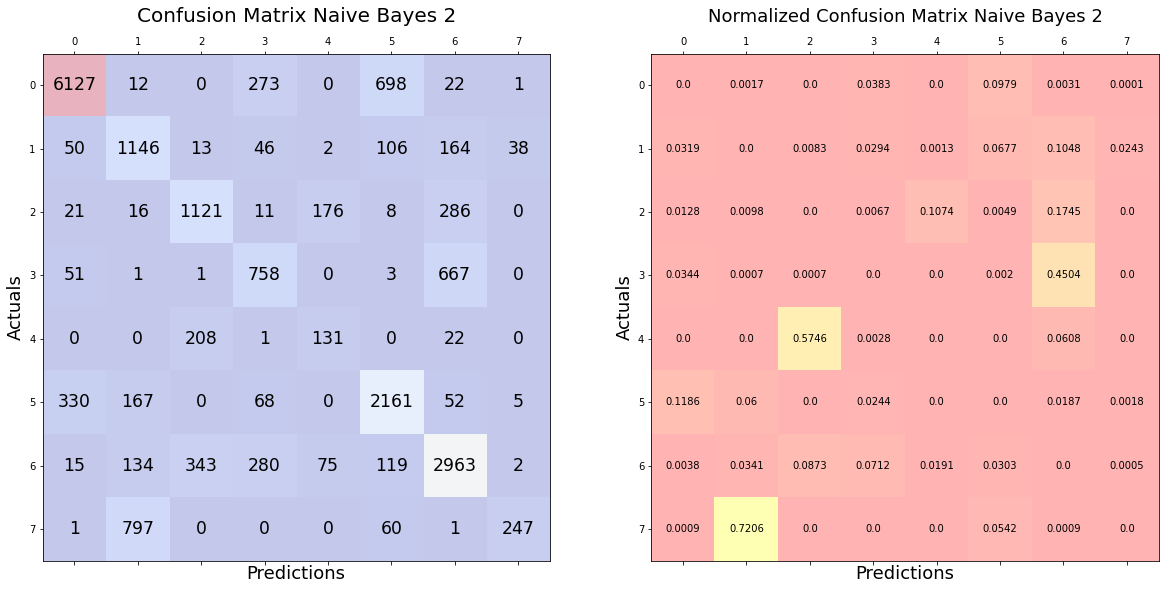

In [71]:
quick_model(NB, 'Naive Bayes 2', X_nb2, y_nb2)

### K-Nearest Neighbors

In [90]:
KNN = KNeighborsClassifier()

X_knn2, y_knn2 = sample_dataset(df_pro2, 100000)


K-Nearest Neighbors 2 Testing set accuracy:  0.85295 

K-Nearest Neighbors 2 Training set accuracy:  0.894125 

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6595
           1       0.87      0.89      0.88      2273
           2       0.75      0.78      0.77      1686
           3       0.68      0.63      0.65      1437
           4       0.56      0.41      0.47       384
           5       0.88      0.86      0.87      3155
           6       0.83      0.85      0.84      4177
           7       0.62      0.43      0.51       293

    accuracy                           0.85     20000
   macro avg       0.77      0.72      0.74     20000
weighted avg       0.85      0.85      0.85     20000
 

K-Nearest Neighbors 2 F1 Score 0.7436637091482388 

Model (average) accuracy:  0.6529899753308447


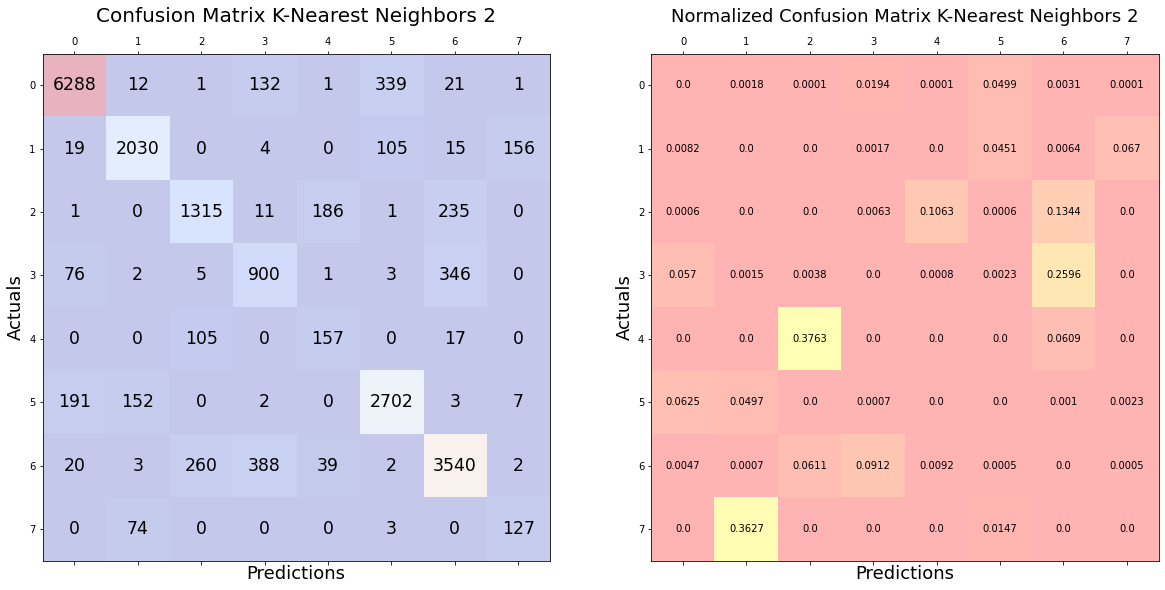

In [91]:
quick_model(KNN, 'K-Nearest Neighbors 2', X_knn2, y_knn2)

### Decision Tree

In [74]:
tree = DecisionTreeClassifier()

X_tree2, y_tree2 = sample_dataset(df_pro2, 100000)


Decision Tree 2 Testing set accuracy:  0.801 

Decision Tree 2 Training set accuracy:  1.0 

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      6595
           1       0.85      0.83      0.84      2273
           2       0.70      0.72      0.71      1686
           3       0.53      0.55      0.54      1437
           4       0.40      0.40      0.40       384
           5       0.82      0.85      0.83      3155
           6       0.79      0.77      0.78      4177
           7       0.43      0.44      0.44       293

    accuracy                           0.80     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.80      0.80      0.80     20000
 

Decision Tree 2 F1 Score 0.6808217280332396 

Model (average) accuracy:  0.8000800050599656


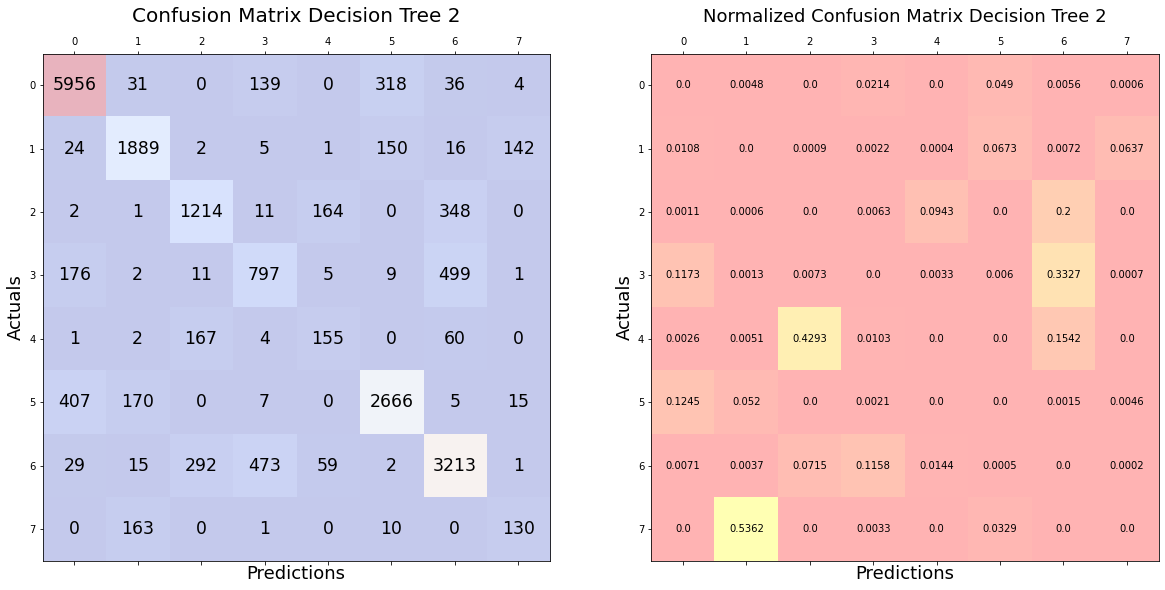

In [75]:
quick_model(tree, "Decision Tree 2", X_tree2, y_tree2)

### Random Forest Classifier

In [76]:
len(df_pro2)

704059

In [77]:
# Default Estimators = 100, criterion = 'gini'
rfc = RandomForestClassifier(n_jobs = -1)

X_rfc2, y_rfc2 = sample_dataset(df_pro2, len(df_pro))


Random Forest 2 Testing set accuracy:  0.8739169957105929 

Random Forest 2 Training set accuracy:  0.99998934747988 

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     46437
           1       0.89      0.91      0.90     16005
           2       0.81      0.80      0.80     11871
           3       0.72      0.63      0.67     10115
           4       0.70      0.47      0.56      2703
           5       0.91      0.88      0.89     22213
           6       0.83      0.89      0.86     29407
           7       0.70      0.46      0.56      2061

    accuracy                           0.87    140812
   macro avg       0.81      0.75      0.77    140812
weighted avg       0.87      0.87      0.87    140812
 

Random Forest 2 F1 Score 0.7740436949781175 

Model (average) accuracy:  0.8733969743652285


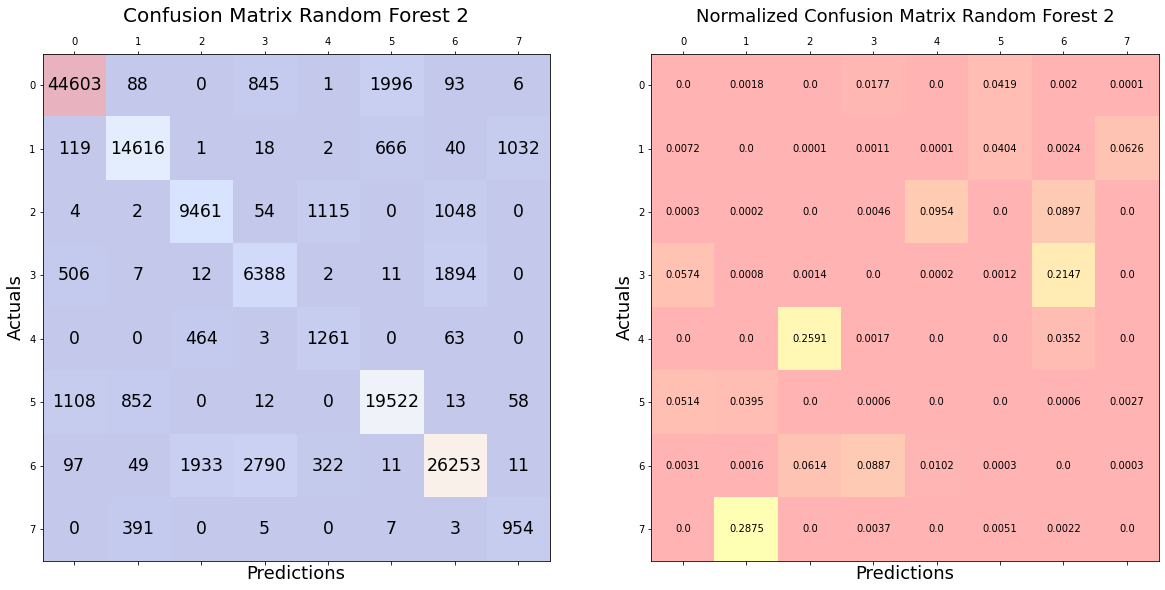

In [78]:
quick_model(rfc, "Random Forest 2", X_rfc2, y_rfc2)

### Findings

In [79]:
performance_df

,Model,Test_Accuracy,Training_Accuracy,F1 Score,Model_Accuracy
0,Naive Bayes,0.725100,0.719975,0.598423,0.720450
1,K-Nearest Neighbors,0.860850,0.902462,0.740107,0.816520
2,Decision Tree,0.807050,1.000000,0.689733,0.807540
3,Random Forest,0.894221,0.999989,0.803657,0.892807
4,Naive Bayes 2,0.732700,0.730088,0.604753,0.729850
5,K-Nearest Neighbors 2,0.858900,0.894437,0.746480,0.653400
6,Decision Tree 2,0.801000,1.000000,0.680822,0.800080
7,Random Forest 2,0.873917,0.999989,0.774044,0.873397


In [80]:
pitch_encoded

label            encoded
4-Seam Fastball  0          33.0
Changeup         1          11.4
Curveball        2           8.4
Cutter           3           7.2
Knuckle Curve    4           1.9
Sinker           5          15.8
Slider           6          20.9
Split-Finger     7           1.5
dtype: float64

Now using second pass features, we can see that eliminating these features did not produce much effect for model performance overall. If there was an effect at all, including the features we eliminated before creating our second pass models only gained us a handful of percentage points, well under the return needed to justify including them in a model. We can now fine-tune our models knowing that we have made a worthwhile sacrifice including a smaller number of features in our dataset.








## Hyperparameters

After examining our second pass models, we will choose to only select the two best performing models to tune hyperparameters for. For the rest of this project, we will choose to focus only on the K-Nearest Neighbors and Random Forest Classifier models. Because of the difference in the amount of hyperparameters and in the interest of time, we will use a GridSearchCV for our KNN model, and a RandomizedSearchCV plus a GridSearchCV for our Random Forest model.

Note that the dataset we will be using for fine-tuning will be the dataset containing only our second pass features. We will simply recall the datasets used for the corresponding second pass model (e.g. KNN second pass X and y will be used for the fine-tuned KNN X and y), inputting them into our fine-tune function.

In [81]:
def fine_tune(x_dataset, y_dataset, search_model):

  X_train, X_test, y_train, y_test = preprocess(x_dataset, y_dataset)

  search_res = search_model.fit(X_train, y_train)

  print("Fine-Tune Best Score", search_res.best_score_)
  print("Fine-Tune Best Hyperparameters", search_res.best_params_)

### KNN

In [82]:
g_search_params = { 'n_neighbors' : [5, 10, 15, 20, 25, 30],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

knn_gs = KNeighborsClassifier()

grid_search = GridSearchCV(knn_gs, g_search_params, verbose = 1, cv=3, n_jobs = -1)

In [83]:
fine_tune(X_knn2, y_knn2, grid_search)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fine-Tune Best Score 0.8619749876129624
Fine-Tune Best Hyperparameters {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}


In [84]:
knn2 = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='manhattan')


K-Nearest Neighbors (Fine-Tuned) Testing set accuracy:  0.86725 

K-Nearest Neighbors (Fine-Tuned) Training set accuracy:  1.0 

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      6595
           1       0.88      0.91      0.89      2273
           2       0.79      0.80      0.79      1686
           3       0.71      0.65      0.68      1437
           4       0.69      0.38      0.49       384
           5       0.90      0.87      0.88      3155
           6       0.84      0.88      0.86      4177
           7       0.69      0.41      0.52       293

    accuracy                           0.87     20000
   macro avg       0.80      0.73      0.76     20000
weighted avg       0.86      0.87      0.86     20000
 

K-Nearest Neighbors (Fine-Tuned) F1 Score 0.7472518510108346 

Model (average) accuracy:  0.7027499584409655


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


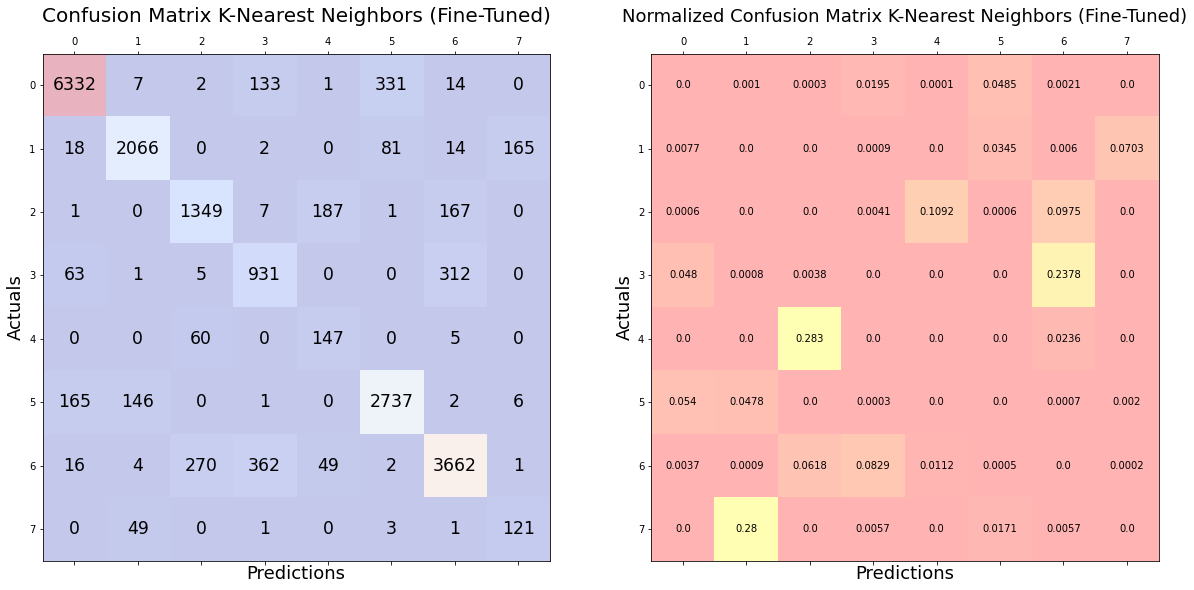

In [96]:
quick_model(knn2, 'K-Nearest Neighbors (Fine-Tuned)', X_knn2, y_knn2)

### Random Forest

Random Forest will have to be fine-tuned a little differently. Not only are we to use the entire dataset which will take more time to fine-tune different models over, but Random Forest Classifiers have a lot of hyperparameters to tune. In essence, we will have to prioritize methods of fine-tuning that can do the task in a shorter amount of time. 

After some searching, I came across some SciKit packages that are built to perform a randomized search but also to save time doing it. These packages are however still considered "experimental," and are still in development [3][4]. However, due to processing concerns, we will still use them to fine-tune our Random Forests.

[3]: SciKit Learn. “sklearn.model_selection.HalvingRandomSearchCV.” Dec 2022, https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html#examples-using-sklearn-model-selection-halvingrandomsearchcv.

[4] SciKit Learn. “sklearn.model_selection.HalvingGridSearchCV.” Dec 2022, https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn.model_selection.HalvingGridSearchCV.

In [97]:
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV

In [98]:
# Number of trees in random forest
n_estimators = [5, 10, 20, 50, 100]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 10)]
max_depth.append(None)

random_search_grid = {'n_estimators': n_estimators, 
                      'max_depth': max_depth,
                      'min_samples_split': [2, 6, 10],
                      'bootstrap': [True, False],
                      }

rfc = RandomForestClassifier(n_jobs = -1)

rand_search = HalvingRandomSearchCV(estimator = rfc, param_distributions= random_search_grid, cv=3, verbose=2, random_state=35, n_jobs= -1)

In [99]:
fine_tune(X_rfc2, y_rfc2, rand_search)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 9
min_resources_: 48
max_resources_: 563247
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 330
n_resources: 48
Fitting 3 folds for each of 330 candidates, totalling 990 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 330 is smaller than n_iter=11734. Running 330 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 110
n_resources: 144
Fitting 3 folds for each of 110 candidates, totalling 330 fits
----------
iter: 2
n_candidates: 37
n_resources: 432
Fitting 3 folds for each of 37 candidates, totalling 111 fits
----------
iter: 3
n_candidates: 13
n_resources: 1296
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 4
n_candidates: 5
n_resources: 3888
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 5
n_candidates: 2
n_resources: 11664
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fine-Tune Best Score 0.8457647462277093
Fine-Tune Best Hyperparameters {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 18, 'bootstrap': True}


With our hyperparameters from a HalvingRandomizedSearch, we see that the hyperparameters we are tuning do not deviate far from the default. This means we can exclude some of the hyperparameters that were determined to be the default values. Next, we'll run a HalvingGridSearchCV, but with our max_depth, n_esimators, and min_samples_split values centered around the result of our HalvingRandomizedSearch. 

In [100]:
gs_params_rfc = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [80, 90, 100, 110]
}
# Create a based model
rfc_gs = RandomForestClassifier(n_jobs = -1)

# Instantiate the grid search model
grid_search_rfc = HalvingGridSearchCV(rfc_gs, gs_params_rfc, verbose = 1, cv=3, n_jobs = -1)

In [101]:
fine_tune(X_rfc2, y_rfc2, grid_search_rfc)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 20861
max_resources_: 563247
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 20861
Fitting 3 folds for each of 60 candidates, totalling 180 fits
----------
iter: 1
n_candidates: 20
n_resources: 62583
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 7
n_resources: 187749
Fitting 3 folds for each of 7 candidates, totalling 21 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 563247
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fine-Tune Best Score 0.8733450866138656
Fine-Tune Best Hyperparameters {'max_depth': 20, 'min_samples_split': 6, 'n_estimators': 110}


In [104]:
rfc2 = RandomForestClassifier(n_estimators = 110, max_depth = 20, min_samples_split = 6, bootstrap = True)


Random Forest (Fine-Tuned) Testing set accuracy:  0.8757918359230747 

Random Forest (Fine-Tuned) Training set accuracy:  0.9291216819619101 

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     46437
           1       0.89      0.92      0.90     16005
           2       0.81      0.80      0.80     11871
           3       0.74      0.63      0.68     10115
           4       0.72      0.45      0.55      2703
           5       0.91      0.88      0.89     22213
           6       0.83      0.90      0.87     29407
           7       0.71      0.44      0.54      2061

    accuracy                           0.88    140812
   macro avg       0.82      0.75      0.77    140812
weighted avg       0.87      0.88      0.87    140812
 

Random Forest (Fine-Tuned) F1 Score 0.7736119524014724 

Model (average) accuracy:  0.8745147793106259


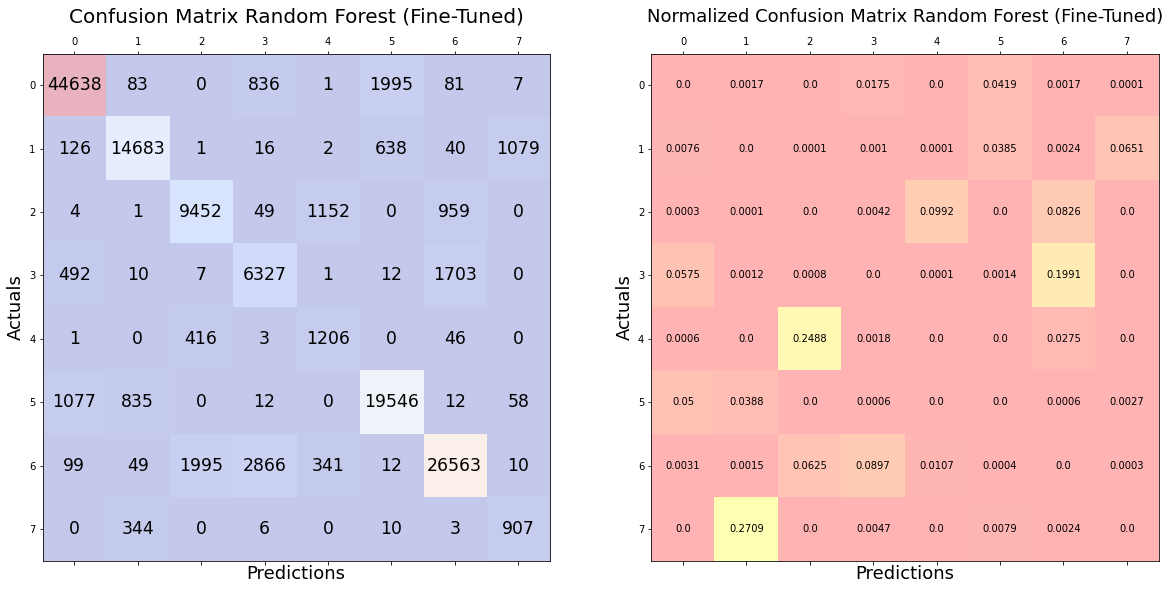

In [105]:
quick_model(rfc2, 'Random Forest (Fine-Tuned)', X_rfc2, y_rfc2)

### Findings


*   Our fine-tuned KNN model gained a couple percentage points of accuracy in comparison to the second pass KNN model, both of which were trained on the same sample dataset. The confusion matrices for both models also show that there was some improvement in errors, including the combinations that produced the greatest proportions of errors. However, there was still significant error in the three combinations of predicition-actual instances identified in the first and second pass models.
*   The Random Forest model took a significant amount of time to fine-tune, with no improvement in performance that can be considered significant. However, the accuracy of the training set did decrease from the previous Random Forest models. Previous models did have the training set accuracy to be near 100%, which meant that the model was overfitting the training set. We may conclude from this that our Random Forest improved not by increasing its accuracy, but by decreasing its overfitting of the training set.



# Conclusion

In this project, we have built a pitch classifier based on all regular season pitch data for the 2022 MLB season. Gathered from Statcast, our dataset was cleaned, transformed, visualized on several different metrics or combinations of metrics, and pre-processed. We tried four different models, which ranged from around 60% to 90% in terms of overall accuracy. The greatest classifications errors found included distinguishing knuckle-curves from curveballs and splitters from changeups, neither of which occurred to the same extent in the other direction. Our models also confused sliders from cutters and curveballs, generating a significant amount of error for cutters predicted as sliders.


We then fine-tuned our K-Nearest Neighbors and Random Forest models to uncover any improvement in accuracy. The K-Nearest Neighbors model gained a few points of accuracy and generated less error overall, but the largest combinations of error persisted. While our Random Forest model did not gain any accuracy, it likely decreased its overfitting of the training set due to decreased accuracy of the model's predictions on the training set. 

As a parting gift, we present a recap of the performance metrics for all models created in this project.

In [106]:
performance_df

,Model,Test_Accuracy,Training_Accuracy,F1 Score,Model_Accuracy
0,Naive Bayes,0.725100,0.719975,0.598423,0.720450
1,K-Nearest Neighbors,0.860850,0.902462,0.740107,0.816520
2,Decision Tree,0.807050,1.000000,0.689733,0.807540
3,Random Forest,0.894221,0.999989,0.803657,0.892807
4,Naive Bayes 2,0.732700,0.730088,0.604753,0.729850
5,K-Nearest Neighbors 2,0.858900,0.894437,0.746480,0.653400
6,Decision Tree 2,0.801000,1.000000,0.680822,0.800080
7,Random Forest 2,0.873917,0.999989,0.774044,0.873397
8,K-Nearest Neighbors (Fine-Tuned),0.867250,1.000000,0.747252,0.702750
9,Random Forest (Fine-Tuned),0.875792,0.929122,0.773612,0.874515
